In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
#Open drugreview files
df_train=pd.read_csv("drugsComTrain_raw.csv")
print("Train Data format " ,df_train.head())
print("Train Data shape ",df_train.shape)
print("Condition count in Train dataset ", df_train['condition'].value_counts())
df_train_cond_rev=df_train[['condition','review']].copy()
df_temp=df_train_cond_rev[pd.notnull(df_train_cond_rev['review'])]
df_train_fil=df_temp[pd.notnull(df_temp['condition'])]
print("Dataset with columns Condition and review" , df_train_fil)
print("Dataset with columns Condition and review dimension " ,df_train_fil.shape)

Train Data format     uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37  
T

In [3]:
# Clean patient condition label with bad data
df_comment = df_train_fil[df_train_fil['condition'].str.contains('comment')]
df_comment

,condition,review
105,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f..."
196,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p..."
243,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a..."
264,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con..."
391,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger..."
...,...,...
160322,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki..."
160791,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T..."
160899,7</span> users found this comment helpful.,"""I&#039;ve been taking Geodon for about a mont..."
160921,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """


In [4]:
# Dropping rows that contain incorrect information 

df_train_fil = df_train_fil[~df_train_fil['condition'].str.contains('comment')]
print(df_train_fil.shape)

(159498, 2)


Birth Control                           28788
Depression                               9069
Pain                                     6145
Anxiety                                  5904
Acne                                     5588
                                        ...  
Short Stature for Age                       1
Myelofibrosis                               1
Short Stature                               1
Gallbladder Disease                         1
Meningococcal Meningitis Prophylaxis        1
Name: condition, Length: 811, dtype: int64


Text(0.5, 1.0, 'Top 50  : The number of reviews per patient condition.')

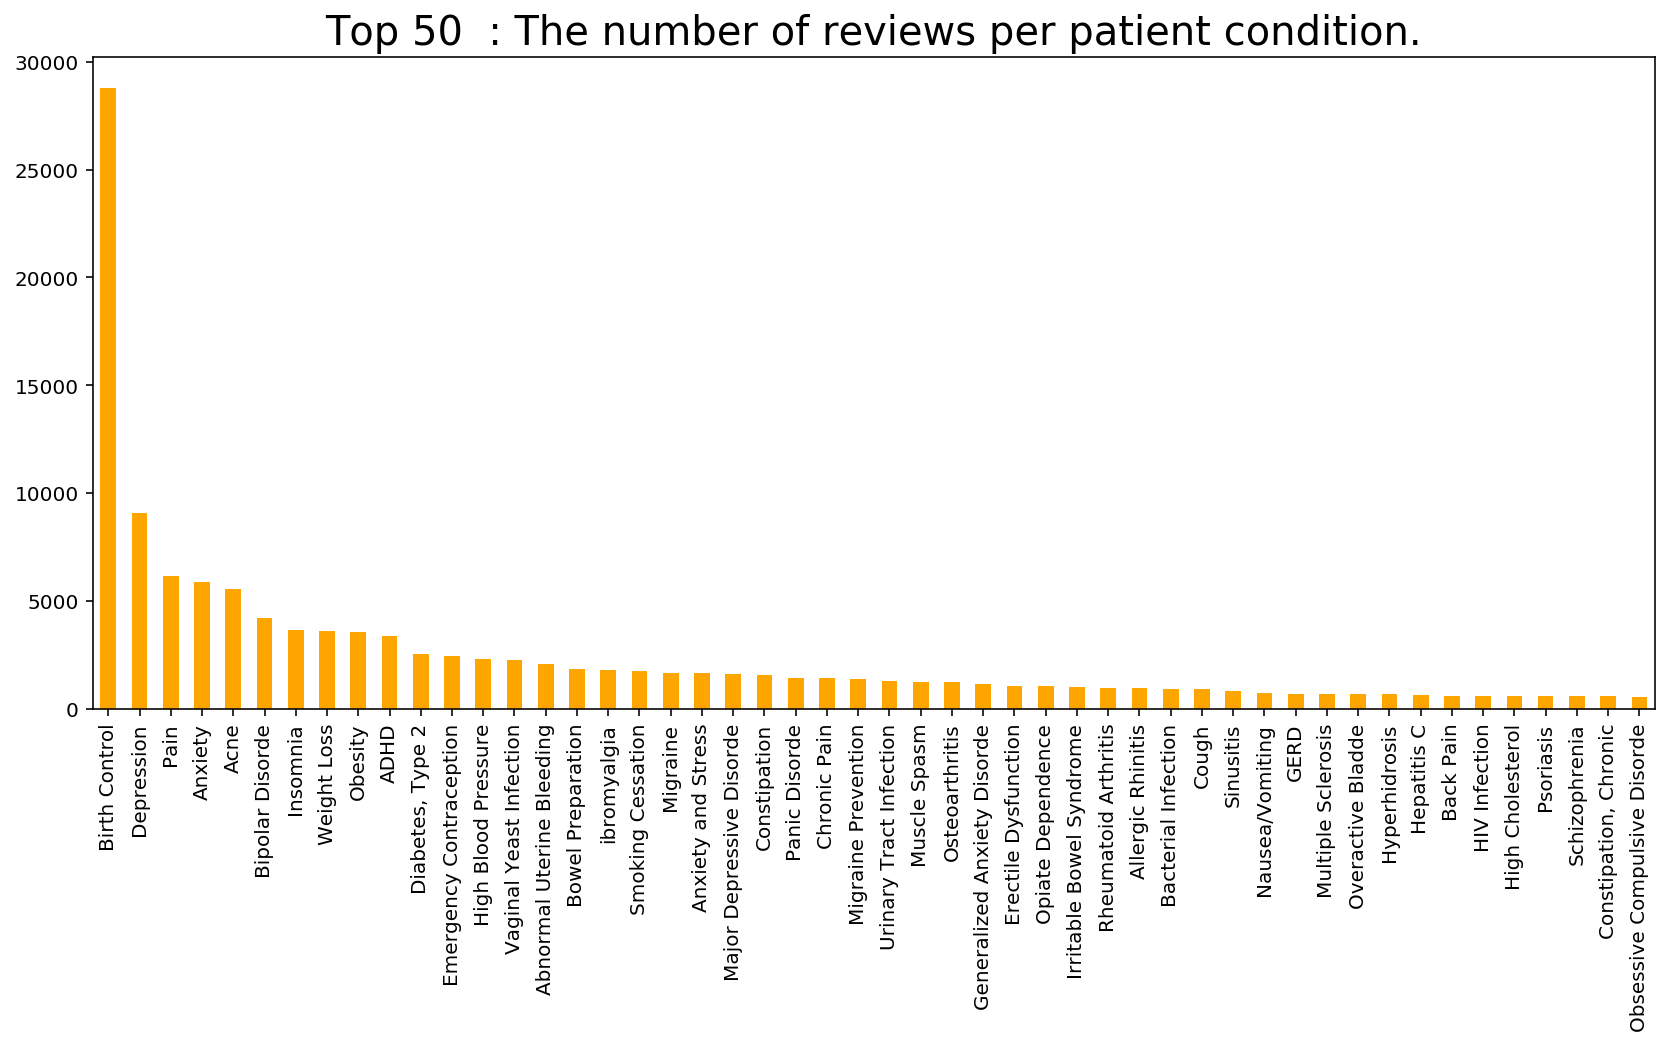

In [5]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:50].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 50  : The number of reviews per patient condition.", fontsize = 20)

In [6]:
value_counts=df_train_fil['condition'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
print(value_counts)

Birth Control                           28788
Depression                               9069
Pain                                     6145
Anxiety                                  5904
Acne                                     5588
                                        ...  
Short Stature for Age                       1
Myelofibrosis                               1
Short Stature                               1
Gallbladder Disease                         1
Meningococcal Meningitis Prophylaxis        1
Name: condition, Length: 811, dtype: int64


In [7]:

to_remove = value_counts[value_counts <= 800].index
# Keep rows where the city column is not in to_remove
df_train_fil = df_train_fil[~df_train_fil.condition.isin(to_remove)]
print(" Dataset after removal",df_train_fil.shape)
df_train_fil.condition.value_counts()

 Dataset after removal (114796, 2)


Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                    1244
O

In [8]:
df_train_fil.replace({'condition':{'Generalized Anxiety Disorde': 'Anxiety Disorder','Anxiety and Stress': 'Anxiety Disorder','Anxiety':'Anxiety Disorder','Major Depressive Disorde':'Depression'}},inplace= True)

In [9]:
df_train_fil.condition.unique()

array(['ADHD', 'Birth Control', 'Opiate Dependence',
       'Emergency Contraception', 'Bipolar Disorde',
       'Migraine Prevention', 'Depression', 'Cough', 'Obesity',
       'Urinary Tract Infection', 'ibromyalgia', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection', 'Panic Disorde',
       'Migraine', 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Muscle Spasm',
       'Diabetes, Type 2', 'Smoking Cessation', 'Anxiety Disorder',
       'Acne', 'Erectile Dysfunction', 'Chronic Pain',
       'High Blood Pressure', 'Allergic Rhinitis',
       'Abnormal Uterine Bleeding', 'Weight Loss', 'Bacterial Infection',
       'Sinusitis'], dtype=object)

Birth Control                28788
Depression                   10676
Anxiety Disorder              8731
Pain                          6145
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Constipation                  1595
Panic Disorde                 1463
Chronic Pain                  1455
Migraine Prevention           1413
Urinary Tract Infection       1316
Muscle Spasm                  1244
Osteoarthritis                1239
Erectile Dysfunction          1086
Opiate Dependence             1079
Irritable Bowel Synd

Text(0.5, 1.0, 'Top 34  : The number of reviews per patient condition.')

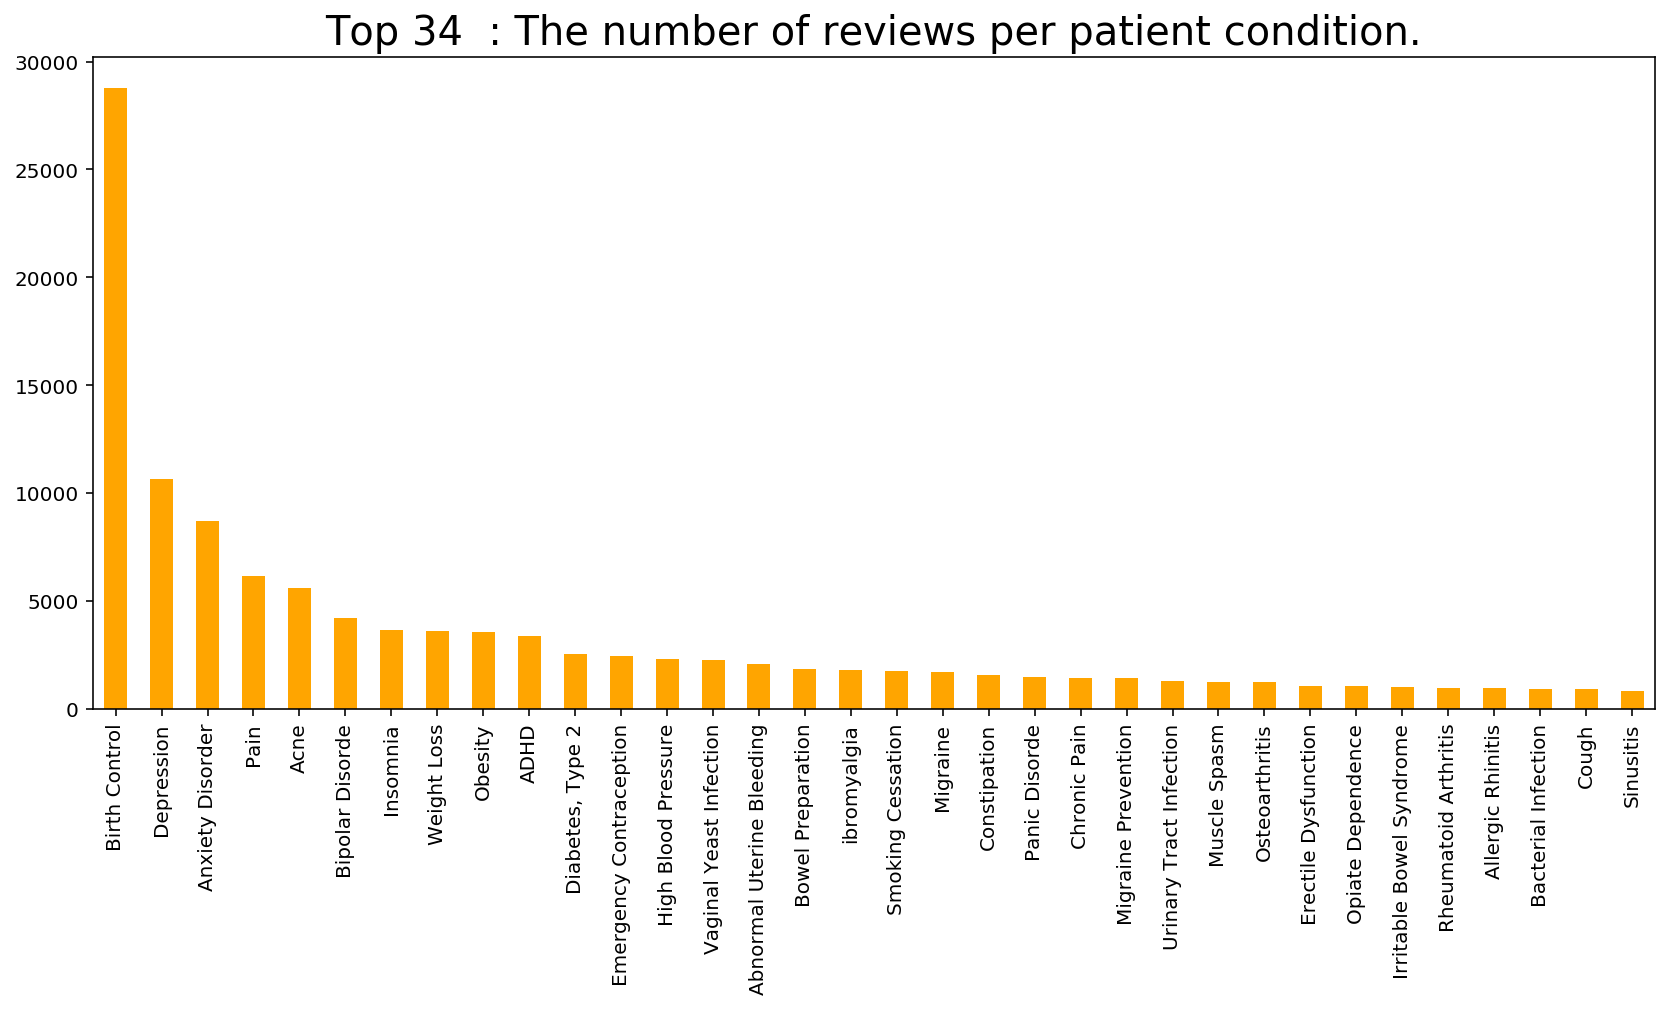

In [10]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:34].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 34  : The number of reviews per patient condition.", fontsize = 20)

In [11]:
df_train_fil = df_train_fil.sample(frac=0.5, replace=True, random_state=1).copy()
df_train_fil.shape

(57398, 2)

In [12]:
#Clean review comments
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\d+]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z00-99 #+_]')
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\','this','will','doctor','took','got','month','an','weight','if','one','week','when','more','are','weeks','are','would','just','feel','day',
 'im','though','daily','found','daily','found','give','7','gained','happy','sure','told','less','gave','three',
 'side','taking','ive','years','first','effects','take','started','like','months','get','days','time','2','feel','would','3',
 'back', 'also','dont','since', 'also','dont','since', 'cant','stop','morning','however','taken','within','see''good','night',
 'even','year','great','ago','4','tried','little','5','dose','used','worked','1','getting','could','10','almost','put','6','use',
 'nothing','far','helped','normal','gain','recommend','without','long','thing','make','many','noticed','said','ood','best',
 'thought','gone','working','couldnt','anything','something','spotting','things','people','second','need','20','way','half',
 'start','another','completely','wasnt','everything','8','face','bit','high','worth','definitely','pretty','decided','actually',
 'lbs','effective','past','today','helps','heavy','new','may','doesnt','30','minutes','15','problem','dry','came','reviews','shot','issues','trying','switched','depressed','12','full','sometimes','find','meds','change','anyone','caused','thats','results','done','increased','twice','energy','fine','several','hard','read','given','pressure','come','clear','eating','already','insurance','everyone','dosage','mouth','amazing','id','enough','wanted','overall','maybe','began','really','still','never','much','work','went','two','didnt','go','made','works','going','mg','hours','last','ever','lost','lot','try','think','stopped',
 'away','know','times','always','havent','next','due','want','around','experienced','finally','able','right','later','different','hour','keep','dr','changed','makes','least','else','difference','seems','needed','product',
 'point','soon','absolutely','anymore','usually','drink','free','stay','became','recently','awful','small','hoping','believe','felt','better','good','every','well','help','feeling','prescribed','severe','experience','using','effect','worse','body','old','love','see','symptoms','eat','drive','problems','light','starting','insertion','attacks','hope','bed','plan','negative','crazy','major','9','whole','gotten','quit','removed','extreme','food','pack','lasted','end','patch','everyday','constant','person','25','reason','others','medications','thoughts','24','yet','tell','reading','etc','regular','although','suffered','cause','10mg','along','asleep','wake','remember','medicines','100','doctors','hair','left','immediately','hurt','part','constantly','school','per','highly','burning','mind','break','positive','b','super','slight','big','short','head','notice','probably','cycle','deal','cleared','either','woke','seem','wish','increase','wait','boyfriend','let','four','50','18','wouldnt','scared','23','20mg','quite','stuff','continue','takes','thinking','literally','worry','beginning','might','recommended','treatment','early','plus','experiencing','taste','home','seemed','huge','ended','kept','easy','husband','doc','hungry','suffer','crying','wont','third','switch','except','become','isnt','prescription','making','16','coming','family','40','fall','yes','goes','luck','quickly','entire','2015','currently','looking','fast','glad','fatigue','attack','please','straight','yrs','2nd','can','not','thank','dreams','withdrawal','trouble','3rd','cream','happened','fact','function','care','often','kind','50mg','hate','kids','amount','late','especially','instead','gets','switching','wonderful','issue','changes','losing','chest','saved','broke','level','worried','live','totally','loved','14','lighter','type','active','nearly','age','prior','feels','intense','real','1st','son','45','rather','baby','decreased','improved','slowly','someone','focus','self','lots','size','normally','5mg','hospital','irregular','six','yesterday','nervous','rest','cry','uncomfortable','supposed','hopefully','guess','drinking','procedure','knew','called','improvement','giving','11','34','youre','walk','form','asked','slightly','developed','bathroom','expensive','suggested','17','look','okay','sleepy','ok','eventually','course','add','2016','knee','stick','must','brand','five','sensitive','health','wonders','minor','child','comes','none','breakouts','hasnt','adderall','saw','cost','review','unfortunately','red','100mg','leave','affects','occasional','helping','hot','breakthrough','serious','possible','usual','zero','single','pay','perfect','levels','hell','nights','sad','legs','total','friends','handle','doses','seen','difficult','prep','easily','13','throughout','slept','minimal','god','social','continued','turned','mine','reduced','seeing','strong','term','ready','truly','upset','happen','lasts','unbearable','wrong','rid','mostly','evening','says','unprotected','march','case','children','place','25mg','vyvanse','moderate','awesome','pm','reaction','post','60','female','causing','higher','easier']

STOPWORDS = set(stopwords.words('english'))
stop_words=STOPWORDS.union(add_stop)
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
        # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
    
df_train_fil['review'] = df_train_fil['review'].apply(clean_text)
#print_plot(10)
df_train_fil

,condition,review
138414,Pain,neurontin nerve pain associated paralysis leg ...
109133,Depression,depression psychology study suicidal selfcontr...
7319,ibromyalgia,lyrica pain walking pillows dizzy drunk lose p...
137741,Bipolar Disorde,psychotic diagnosis bipolar mood stabilizer ru...
70413,Birth Control,close together sake sanity remembering pills s...
...,...,...
76462,"Diabetes, Type 2",discontinued horrible throwing spent iv fluids...
94780,Emergency Contraception,ella protected sex condom sleep running wild f...
114328,Depression,slipped suicidal ideations rheumatological dis...
4350,Birth Control,bc mood swings weak tiredbut nexplanon blame a...


In [13]:
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
reviews = df_train_fil.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:200]

34339


['pain',
 'pill',
 'period',
 'anxiety',
 'bad',
 'medication',
 'life',
 'control',
 'acne',
 'birth',
 'depression',
 'medicine',
 'sleep',
 'mood',
 'periods',
 'bleeding',
 'sex',
 'cramps',
 'drug',
 'skin',
 'nausea',
 'pills',
 'horrible',
 'pounds',
 'swings',
 'blood',
 'headaches',
 'panic',
 'stomach',
 'worst',
 'couple',
 'pregnant',
 'cramping',
 'appetite',
 'painful',
 'loss',
 'terrible',
 'tired',
 'extremely',
 'longer',
 'water',
 'migraines',
 'relief',
 'th',
 'inserted',
 'headache',
 'low',
 'mirena',
 'ill',
 'mild',
 'lose',
 'lexapro',
 'insomnia',
 'infection',
 'nexplanon',
 'med',
 'pregnancy',
 'sick',
 'diagnosed',
 'disorder',
 'sleeping',
 'exercise',
 'migraine',
 'x',
 'nauseous',
 'zoloft',
 'diet',
 'job',
 'heart',
 'lower',
 'bc',
 'iud',
 'chronic',
 'emotional',
 'implanon',
 'diarrhea',
 'miracle',
 'xanax',
 'bipolar',
 'stress',
 'implant',
 'constipation',
 'cymbalta',
 'anxious',
 'moody',
 'er',
 'dizzy',
 'muscle',
 'generic',
 'nd',
 's

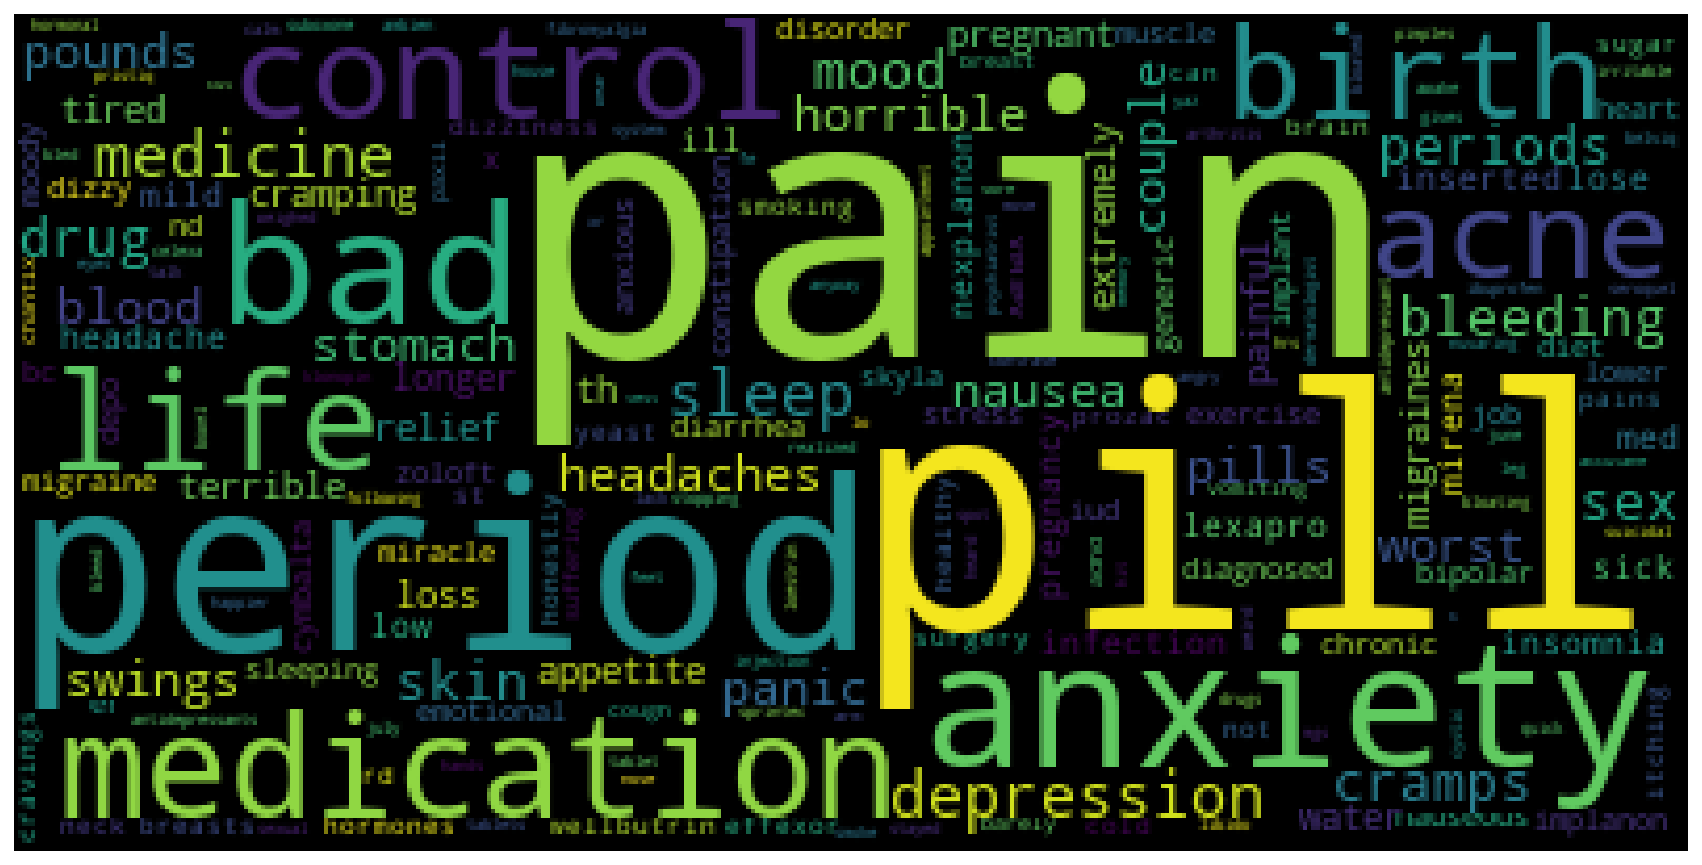

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure( figsize=(15,8) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train_fil['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 34337 unique tokens.


In [16]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df_train_fil['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (57398, 250)


In [17]:
Y = pd.get_dummies(df_train_fil['condition']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57398, 34)


In [18]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')
X_sm,y_sm=smote.fit_sample(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_sm,y_sm, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(64207, 250) (64207, 34)
(7135, 250) (7135, 34)


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(34, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 34)                3434      
Total params: 5,083,834
Trainable params: 5,083,834
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 57786 samples, validate on 6421 samples
Epoch 1/5


   64/57786 [..............................] - ETA: 43:53 - loss: 3.5271 - accuracy: 0.0469

  128/57786 [..............................] - ETA: 35:18 - loss: 3.5227 - accuracy: 0.0469

  192/57786 [..............................] - ETA: 32:03 - loss: 3.5204 - accuracy: 0.1094

  256/57786 [..............................] - ETA: 30:21 - loss: 3.5189 - accuracy: 0.1289

  320/57786 [..............................] - ETA: 29:18 - loss: 3.5170 - accuracy: 0.1562

  384/57786 [..............................] - ETA: 28:42 - loss: 3.5150 - accuracy: 0.1589

  448/57786 [..............................] - ETA: 28:47 - loss: 3.5098 - accuracy: 0.1696

  512/57786 [..............................] - ETA: 28:23 - loss: 3.5055 - accuracy: 0.1855

  576/57786 [..............................] - ETA: 28:00 - loss: 3.5023 - accuracy: 0.1858

  640/57786 [..............................] - ETA: 27:33 - loss: 3.4952 - accuracy: 0.1937

  704/57786 [..............................] - ETA: 27:18 - loss: 3.4851 - accuracy: 0.2045

  768/57786 [..............................] - ETA: 27:06 - loss: 3.4701 - accuracy: 0.2122

  832/57786 [..............................] - ETA: 26:55 - loss: 3.4523 - accuracy: 0.2139

  896/57786 [..............................] - ETA: 26:40 - loss: 3.4212 - accuracy: 0.2165

  960/57786 [..............................] - ETA: 26:32 - loss: 3.4012 - accuracy: 0.2146

 1024/57786 [..............................] - ETA: 26:20 - loss: 3.3797 - accuracy: 0.2129

 1088/57786 [..............................] - ETA: 26:15 - loss: 3.3603 - accuracy: 0.2114

 1152/57786 [..............................] - ETA: 26:08 - loss: 3.3359 - accuracy: 0.2127

 1216/57786 [..............................] - ETA: 25:59 - loss: 3.3208 - accuracy: 0.2081

 1280/57786 [..............................] - ETA: 25:54 - loss: 3.3075 - accuracy: 0.2094

 1344/57786 [..............................] - ETA: 25:50 - loss: 3.2837 - accuracy: 0.2068

 1408/57786 [..............................] - ETA: 25:42 - loss: 3.2767 - accuracy: 0.2074

 1472/57786 [..............................] - ETA: 25:37 - loss: 3.2470 - accuracy: 0.2092

 1536/57786 [..............................] - ETA: 25:34 - loss: 3.2312 - accuracy: 0.2083

 1600/57786 [..............................] - ETA: 25:27 - loss: 3.2220 - accuracy: 0.2106

 1664/57786 [..............................] - ETA: 25:25 - loss: 3.2036 - accuracy: 0.2121

 1728/57786 [..............................] - ETA: 25:21 - loss: 3.1906 - accuracy: 0.2106

 1792/57786 [..............................] - ETA: 25:18 - loss: 3.1856 - accuracy: 0.2104

 1856/57786 [..............................] - ETA: 25:13 - loss: 3.1680 - accuracy: 0.2123

 1920/57786 [..............................] - ETA: 25:09 - loss: 3.1571 - accuracy: 0.2104

 1984/57786 [>.............................] - ETA: 25:05 - loss: 3.1441 - accuracy: 0.2102

 2048/57786 [>.............................] - ETA: 25:01 - loss: 3.1389 - accuracy: 0.2095

 2112/57786 [>.............................] - ETA: 24:57 - loss: 3.1318 - accuracy: 0.2098

 2176/57786 [>.............................] - ETA: 24:52 - loss: 3.1277 - accuracy: 0.2105

 2240/57786 [>.............................] - ETA: 24:53 - loss: 3.1189 - accuracy: 0.2098

 2304/57786 [>.............................] - ETA: 24:48 - loss: 3.1173 - accuracy: 0.2096

 2368/57786 [>.............................] - ETA: 24:44 - loss: 3.1053 - accuracy: 0.2095

 2432/57786 [>.............................] - ETA: 24:41 - loss: 3.1030 - accuracy: 0.2093

 2496/57786 [>.............................] - ETA: 24:39 - loss: 3.0990 - accuracy: 0.2087

 2560/57786 [>.............................] - ETA: 24:36 - loss: 3.0951 - accuracy: 0.2094

 2624/57786 [>.............................] - ETA: 24:32 - loss: 3.0804 - accuracy: 0.2096

 2688/57786 [>.............................] - ETA: 24:29 - loss: 3.0814 - accuracy: 0.2080

 2752/57786 [>.............................] - ETA: 24:26 - loss: 3.0748 - accuracy: 0.2082

 2816/57786 [>.............................] - ETA: 24:26 - loss: 3.0742 - accuracy: 0.2074

 2880/57786 [>.............................] - ETA: 24:22 - loss: 3.0687 - accuracy: 0.2094

 2944/57786 [>.............................] - ETA: 24:20 - loss: 3.0616 - accuracy: 0.2103

 3008/57786 [>.............................] - ETA: 24:17 - loss: 3.0578 - accuracy: 0.2104

 3072/57786 [>.............................] - ETA: 24:13 - loss: 3.0572 - accuracy: 0.2093

 3136/57786 [>.............................] - ETA: 24:10 - loss: 3.0578 - accuracy: 0.2089

 3200/57786 [>.............................] - ETA: 24:07 - loss: 3.0489 - accuracy: 0.2097

 3264/57786 [>.............................] - ETA: 24:04 - loss: 3.0485 - accuracy: 0.2093

 3328/57786 [>.............................] - ETA: 24:01 - loss: 3.0428 - accuracy: 0.2094

 3392/57786 [>.............................] - ETA: 23:58 - loss: 3.0393 - accuracy: 0.2111

 3456/57786 [>.............................] - ETA: 23:55 - loss: 3.0383 - accuracy: 0.2118

 3520/57786 [>.............................] - ETA: 23:53 - loss: 3.0367 - accuracy: 0.2119

 3584/57786 [>.............................] - ETA: 23:51 - loss: 3.0319 - accuracy: 0.2137

 3648/57786 [>.............................] - ETA: 23:49 - loss: 3.0282 - accuracy: 0.2146

 3712/57786 [>.............................] - ETA: 23:46 - loss: 3.0262 - accuracy: 0.2147

 3776/57786 [>.............................] - ETA: 23:43 - loss: 3.0241 - accuracy: 0.2142

 3840/57786 [>.............................] - ETA: 23:40 - loss: 3.0236 - accuracy: 0.2148

 3904/57786 [=>............................] - ETA: 23:38 - loss: 3.0211 - accuracy: 0.2154

 3968/57786 [=>............................] - ETA: 23:37 - loss: 3.0194 - accuracy: 0.2155

 4032/57786 [=>............................] - ETA: 23:35 - loss: 3.0158 - accuracy: 0.2160

 4096/57786 [=>............................] - ETA: 23:33 - loss: 3.0129 - accuracy: 0.2158

 4160/57786 [=>............................] - ETA: 23:31 - loss: 3.0101 - accuracy: 0.2171

 4224/57786 [=>............................] - ETA: 23:30 - loss: 3.0060 - accuracy: 0.2197

 4288/57786 [=>............................] - ETA: 23:27 - loss: 3.0002 - accuracy: 0.2206

 4352/57786 [=>............................] - ETA: 23:24 - loss: 2.9965 - accuracy: 0.2208

 4416/57786 [=>............................] - ETA: 23:23 - loss: 2.9902 - accuracy: 0.2233

 4480/57786 [=>............................] - ETA: 23:21 - loss: 2.9899 - accuracy: 0.2230

 4544/57786 [=>............................] - ETA: 23:20 - loss: 2.9867 - accuracy: 0.2245

 4608/57786 [=>............................] - ETA: 23:21 - loss: 2.9830 - accuracy: 0.2263

 4672/57786 [=>............................] - ETA: 23:20 - loss: 2.9821 - accuracy: 0.2260

 4736/57786 [=>............................] - ETA: 23:18 - loss: 2.9775 - accuracy: 0.2266

 4800/57786 [=>............................] - ETA: 23:15 - loss: 2.9729 - accuracy: 0.2273

 4864/57786 [=>............................] - ETA: 23:13 - loss: 2.9705 - accuracy: 0.2280

 4928/57786 [=>............................] - ETA: 23:11 - loss: 2.9696 - accuracy: 0.2279

In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

  32/7135 [..............................] - ETA: 42s

  64/7135 [..............................] - ETA: 45s

  96/7135 [..............................] - ETA: 44s

 128/7135 [..............................] - ETA: 45s

 160/7135 [..............................] - ETA: 47s

 192/7135 [..............................] - ETA: 47s

 224/7135 [..............................] - ETA: 46s

 256/7135 [>.............................] - ETA: 45s

 288/7135 [>.............................] - ETA: 47s

 320/7135 [>.............................] - ETA: 46s

 352/7135 [>.............................] - ETA: 46s

 384/7135 [>.............................] - ETA: 45s

 416/7135 [>.............................] - ETA: 45s

 448/7135 [>.............................] - ETA: 46s

 480/7135 [=>............................] - ETA: 45s

 512/7135 [=>............................] - ETA: 45s

 544/7135 [=>............................] - ETA: 45s

 576/7135 [=>............................] - ETA: 45s

 608/7135 [=>............................] - ETA: 44s

 640/7135 [=>............................] - ETA: 44s

 672/7135 [=>............................] - ETA: 44s

 704/7135 [=>............................] - ETA: 43s

 736/7135 [==>...........................] - ETA: 44s

 768/7135 [==>...........................] - ETA: 43s

 800/7135 [==>...........................] - ETA: 43s

 832/7135 [==>...........................] - ETA: 43s

 864/7135 [==>...........................] - ETA: 42s

 896/7135 [==>...........................] - ETA: 43s

 928/7135 [==>...........................] - ETA: 42s

 960/7135 [===>..........................] - ETA: 42s

 992/7135 [===>..........................] - ETA: 42s

1024/7135 [===>..........................] - ETA: 42s

1056/7135 [===>..........................] - ETA: 41s

1088/7135 [===>..........................] - ETA: 41s

1120/7135 [===>..........................] - ETA: 41s

1152/7135 [===>..........................] - ETA: 41s

1184/7135 [===>..........................] - ETA: 41s

1216/7135 [====>.........................] - ETA: 40s

1248/7135 [====>.........................] - ETA: 40s

1280/7135 [====>.........................] - ETA: 40s

1312/7135 [====>.........................] - ETA: 40s

1344/7135 [====>.........................] - ETA: 39s

1376/7135 [====>.........................] - ETA: 39s

1408/7135 [====>.........................] - ETA: 39s

1440/7135 [=====>........................] - ETA: 39s

1472/7135 [=====>........................] - ETA: 38s

1504/7135 [=====>........................] - ETA: 38s

1536/7135 [=====>........................] - ETA: 38s

1568/7135 [=====>........................] - ETA: 38s

1600/7135 [=====>........................] - ETA: 38s

1632/7135 [=====>........................] - ETA: 38s

1664/7135 [=====>........................] - ETA: 38s

1696/7135 [======>.......................] - ETA: 38s

1728/7135 [======>.......................] - ETA: 37s

1760/7135 [======>.......................] - ETA: 37s

1792/7135 [======>.......................] - ETA: 37s

1824/7135 [======>.......................] - ETA: 37s

1856/7135 [======>.......................] - ETA: 37s

1888/7135 [======>.......................] - ETA: 36s

1920/7135 [=======>......................] - ETA: 36s

1952/7135 [=======>......................] - ETA: 36s

1984/7135 [=======>......................] - ETA: 36s

2016/7135 [=======>......................] - ETA: 35s

2048/7135 [=======>......................] - ETA: 35s

2080/7135 [=======>......................] - ETA: 35s

2112/7135 [=======>......................] - ETA: 34s

2144/7135 [========>.....................] - ETA: 34s

2176/7135 [========>.....................] - ETA: 34s

2208/7135 [========>.....................] - ETA: 34s

2240/7135 [========>.....................] - ETA: 33s

2272/7135 [========>.....................] - ETA: 33s

2304/7135 [========>.....................] - ETA: 33s

2336/7135 [========>.....................] - ETA: 33s

2368/7135 [========>.....................] - ETA: 33s

2400/7135 [=========>....................] - ETA: 32s

2432/7135 [=========>....................] - ETA: 32s

2464/7135 [=========>....................] - ETA: 32s

2496/7135 [=========>....................] - ETA: 32s

2528/7135 [=========>....................] - ETA: 31s

2560/7135 [=========>....................] - ETA: 31s

2592/7135 [=========>....................] - ETA: 31s

2624/7135 [==========>...................] - ETA: 31s

2656/7135 [==========>...................] - ETA: 31s

2688/7135 [==========>...................] - ETA: 30s

2720/7135 [==========>...................] - ETA: 30s

2752/7135 [==========>...................] - ETA: 30s

2784/7135 [==========>...................] - ETA: 30s

2816/7135 [==========>...................] - ETA: 29s

2848/7135 [==========>...................] - ETA: 29s

2880/7135 [===========>..................] - ETA: 29s

2912/7135 [===========>..................] - ETA: 29s

2944/7135 [===========>..................] - ETA: 28s

2976/7135 [===========>..................] - ETA: 28s

3008/7135 [===========>..................] - ETA: 28s

3040/7135 [===========>..................] - ETA: 28s

3072/7135 [===========>..................] - ETA: 28s

3104/7135 [============>.................] - ETA: 27s

3136/7135 [============>.................] - ETA: 27s

3168/7135 [============>.................] - ETA: 27s

3200/7135 [============>.................] - ETA: 27s

3232/7135 [============>.................] - ETA: 27s

3264/7135 [============>.................] - ETA: 26s

3296/7135 [============>.................] - ETA: 26s

3328/7135 [============>.................] - ETA: 26s

3360/7135 [=============>................] - ETA: 26s

3392/7135 [=============>................] - ETA: 26s

3424/7135 [=============>................] - ETA: 25s

3456/7135 [=============>................] - ETA: 25s

3488/7135 [=============>................] - ETA: 25s

3520/7135 [=============>................] - ETA: 25s

3552/7135 [=============>................] - ETA: 24s

3584/7135 [==============>...............] - ETA: 24s

3616/7135 [==============>...............] - ETA: 24s

3648/7135 [==============>...............] - ETA: 24s

3680/7135 [==============>...............] - ETA: 23s

3712/7135 [==============>...............] - ETA: 23s

3744/7135 [==============>...............] - ETA: 23s

3776/7135 [==============>...............] - ETA: 23s

3808/7135 [===============>..............] - ETA: 22s

3840/7135 [===============>..............] - ETA: 22s

3872/7135 [===============>..............] - ETA: 22s

3904/7135 [===============>..............] - ETA: 22s

3936/7135 [===============>..............] - ETA: 21s

3968/7135 [===============>..............] - ETA: 21s

4000/7135 [===============>..............] - ETA: 21s

4032/7135 [===============>..............] - ETA: 21s

4064/7135 [================>.............] - ETA: 21s

4096/7135 [================>.............] - ETA: 20s

4128/7135 [================>.............] - ETA: 20s

4160/7135 [================>.............] - ETA: 20s

4192/7135 [================>.............] - ETA: 20s

4224/7135 [================>.............] - ETA: 19s

4256/7135 [================>.............] - ETA: 19s

4288/7135 [=================>............] - ETA: 19s

4320/7135 [=================>............] - ETA: 19s

4352/7135 [=================>............] - ETA: 18s

4384/7135 [=================>............] - ETA: 18s

4416/7135 [=================>............] - ETA: 18s

4448/7135 [=================>............] - ETA: 18s

4480/7135 [=================>............] - ETA: 18s

4512/7135 [=================>............] - ETA: 17s

4544/7135 [==================>...........] - ETA: 17s

4576/7135 [==================>...........] - ETA: 17s

4608/7135 [==================>...........] - ETA: 17s

4640/7135 [==================>...........] - ETA: 17s

4672/7135 [==================>...........] - ETA: 16s

4704/7135 [==================>...........] - ETA: 16s

4736/7135 [==================>...........] - ETA: 16s

4768/7135 [===================>..........] - ETA: 16s

4800/7135 [===================>..........] - ETA: 15s

4832/7135 [===================>..........] - ETA: 15s

4864/7135 [===================>..........] - ETA: 15s

4896/7135 [===================>..........] - ETA: 15s

4928/7135 [===================>..........] - ETA: 15s

4960/7135 [===================>..........] - ETA: 14s

4992/7135 [===================>..........] - ETA: 14s

5024/7135 [====================>.........] - ETA: 14s

5056/7135 [====================>.........] - ETA: 14s

5088/7135 [====================>.........] - ETA: 13s

5120/7135 [====================>.........] - ETA: 13s

5152/7135 [====================>.........] - ETA: 13s

5184/7135 [====================>.........] - ETA: 13s

5216/7135 [====================>.........] - ETA: 13s

5248/7135 [=====================>........] - ETA: 12s

5280/7135 [=====================>........] - ETA: 12s

5312/7135 [=====================>........] - ETA: 12s

5344/7135 [=====================>........] - ETA: 12s

5376/7135 [=====================>........] - ETA: 11s

5408/7135 [=====================>........] - ETA: 11s

5440/7135 [=====================>........] - ETA: 11s

5472/7135 [======================>.......] - ETA: 11s

5504/7135 [======================>.......] - ETA: 11s

5536/7135 [======================>.......] - ETA: 10s

5568/7135 [======================>.......] - ETA: 10s

5600/7135 [======================>.......] - ETA: 10s

5632/7135 [======================>.......] - ETA: 10s

5664/7135 [======================>.......] - ETA: 9s 

5696/7135 [======================>.......] - ETA: 9s

5728/7135 [=======================>......] - ETA: 9s

5760/7135 [=======================>......] - ETA: 9s

5792/7135 [=======================>......] - ETA: 9s

5824/7135 [=======================>......] - ETA: 8s

5856/7135 [=======================>......] - ETA: 8s

5888/7135 [=======================>......] - ETA: 8s

5920/7135 [=======================>......] - ETA: 8s

5952/7135 [========================>.....] - ETA: 7s

5984/7135 [========================>.....] - ETA: 7s

6016/7135 [========================>.....] - ETA: 7s



6048/7135 [========================>.....] - ETA: 7s

6080/7135 [========================>.....] - ETA: 7s

6112/7135 [========================>.....] - ETA: 6s

6144/7135 [========================>.....] - ETA: 6s

6176/7135 [========================>.....] - ETA: 6s

6208/7135 [=========================>....] - ETA: 6s

6240/7135 [=========================>....] - ETA: 6s

6272/7135 [=========================>....] - ETA: 5s

6304/7135 [=========================>....] - ETA: 5s

6336/7135 [=========================>....] - ETA: 5s

6368/7135 [=========================>....] - ETA: 5s

6400/7135 [=========================>....] - ETA: 4s

6432/7135 [==========================>...] - ETA: 4s

6464/7135 [==========================>...] - ETA: 4s

6496/7135 [==========================>...] - ETA: 4s

6528/7135 [==========================>...] - ETA: 4s

6560/7135 [==========================>...] - ETA: 3s

6592/7135 [==========================>...] - ETA: 3s

6624/7135 [==========================>...] - ETA: 3s

6656/7135 [==========================>...] - ETA: 3s

6688/7135 [===========================>..] - ETA: 3s

6720/7135 [===========================>..] - ETA: 2s

6752/7135 [===========================>..] - ETA: 2s

6784/7135 [===========================>..] - ETA: 2s

6816/7135 [===========================>..] - ETA: 2s

6848/7135 [===========================>..] - ETA: 1s

6880/7135 [===========================>..] - ETA: 1s

6912/7135 [============================>.] - ETA: 1s

6944/7135 [============================>.] - ETA: 1s

6976/7135 [============================>.] - ETA: 1s

7008/7135 [============================>.] - ETA: 0s

7040/7135 [============================>.] - ETA: 0s

7072/7135 [============================>.] - ETA: 0s

7104/7135 [============================>.] - ETA: 0s

7135/7135 [==============================] - 48s 7ms/step


Test set
  Loss: 0.730
  Accuracy: 0.801


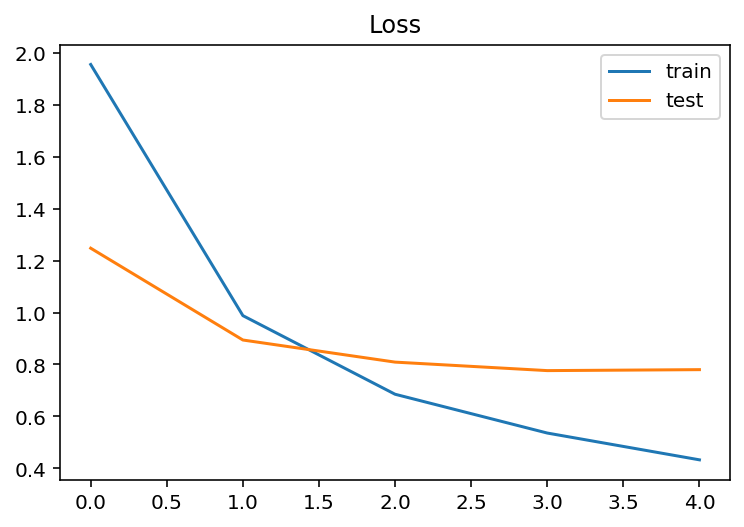

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

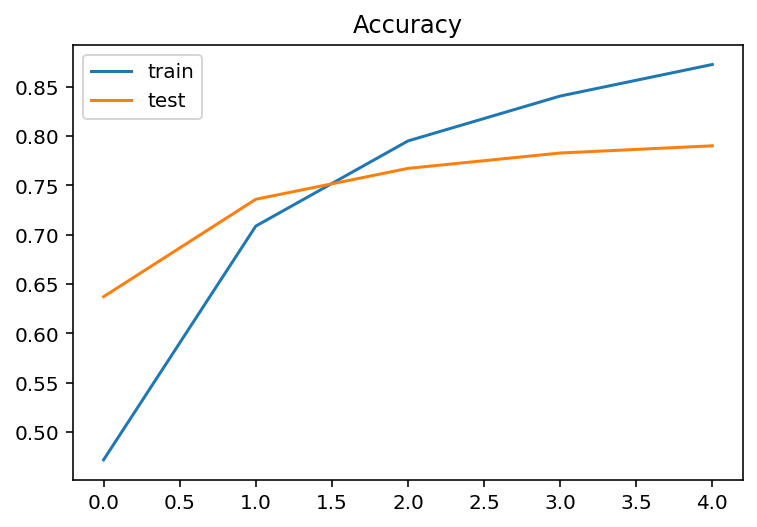

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [30]:
print(history.history)

{'val_loss': [1.3032740156260463, 0.856342522772655, 0.7175680652655312, 0.6727806388198804, 0.6691028300093617], 'val_accuracy': [0.5845214128494263, 0.7331975698471069, 0.7790223956108093, 0.7881873846054077, 0.7970129251480103], 'loss': [1.947168549285571, 1.092885662290657, 0.7579767355806654, 0.584208793717835, 0.47399557336454445], 'accuracy': [0.4373114, 0.6492532, 0.7604481, 0.81299037, 0.84716356]}


In [31]:
import nltk
from nltk.tokenize import word_tokenize
reviews = df_train_fil.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[500:1000]

55304


['hands',
 'realized',
 'process',
 'sprintec',
 'appointment',
 'following',
 'stopping',
 'july',
 'spot',
 'lack',
 'tablets',
 'talk',
 'belviq',
 'hit',
 'test',
 'system',
 'rate',
 'afraid',
 'leg',
 'hrs',
 'sexual',
 'move',
 'june',
 'psychiatrist',
 '21',
 'inside',
 'happier',
 'stayed',
 '75',
 'house',
 'eyes',
 'ones',
 'gives',
 'combination',
 'discomfort',
 'awake',
 'moods',
 '30mg',
 'exactly',
 'anyway',
 'weighed',
 'feet',
 'condom',
 'college',
 'hardly',
 'tablet',
 'epiduo',
 'annoying',
 'quick',
 'extra',
 'close',
 'weigh',
 '19',
 'nice',
 'area',
 'discharge',
 'forget',
 'mental',
 'women',
 'lamictal',
 'ring',
 'tolerance',
 'added',
 'heard',
 'feelings',
 '40mg',
 '35',
 'miserable',
 'finished',
 'chin',
 'wear',
 'phentermine',
 'middle',
 'unable',
 'thanks',
 'daughter',
 'emotions',
 'waking',
 'august',
 'run',
 'method',
 'pms',
 'nerve',
 'basically',
 'walking',
 'miss',
 'matter',
 'sweating',
 'initially',
 'keeps',
 'memory',
 'lyrica',
 

In [32]:
X_train.shape

(99108, 250)

In [33]:
Y_train.shape

(99108, 32)

In [20]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')
X_sm,y_sm=smote.fit_sample(X_train,Y_train)
print(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


NameError: name 'X_train' is not defined

In [40]:
print(X_sm.shape,y_sm.shape)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train),
                                                 Y_train)

(124097, 250) (124097, 32)


TypeError: unhashable type: 'numpy.ndarray'

In [41]:
epochs = 5
batch_size = 128

history = model.fit(X_sm, y_sm, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 99277 samples, validate on 24820 samples


Epoch 1/5


  128/99277 [..............................] - ETA: 40:13 - loss: 0.3657 - accuracy: 0.8906

  256/99277 [..............................] - ETA: 36:45 - loss: 0.3683 - accuracy: 0.8984

  384/99277 [..............................] - ETA: 37:19 - loss: 0.3836 - accuracy: 0.8880

  512/99277 [..............................] - ETA: 36:54 - loss: 0.3828 - accuracy: 0.8809

  640/99277 [..............................] - ETA: 36:12 - loss: 0.3808 - accuracy: 0.8906

  768/99277 [..............................] - ETA: 35:41 - loss: 0.3717 - accuracy: 0.8880

  896/99277 [..............................] - ETA: 35:18 - loss: 0.3656 - accuracy: 0.8929

 1024/99277 [..............................] - ETA: 35:22 - loss: 0.3616 - accuracy: 0.8955

 1152/99277 [..............................] - ETA: 34:57 - loss: 0.3636 - accuracy: 0.8941

 1280/99277 [..............................] - ETA: 34:42 - loss: 0.3621 - accuracy: 0.8961

 1408/99277 [..............................] - ETA: 34:31 - loss: 0.3623 - accuracy: 0.8963

 1536/99277 [..............................] - ETA: 34:22 - loss: 0.3562 - accuracy: 0.8997

 1664/99277 [..............................] - ETA: 34:13 - loss: 0.3703 - accuracy: 0.8960

 1792/99277 [..............................] - ETA: 34:00 - loss: 0.3725 - accuracy: 0.8940

 1920/99277 [..............................] - ETA: 34:03 - loss: 0.3756 - accuracy: 0.8906

 2048/99277 [..............................] - ETA: 33:56 - loss: 0.3737 - accuracy: 0.8906

 2176/99277 [..............................] - ETA: 33:50 - loss: 0.3847 - accuracy: 0.8874

 2304/99277 [..............................] - ETA: 33:44 - loss: 0.3928 - accuracy: 0.8859

 2432/99277 [..............................] - ETA: 33:38 - loss: 0.3943 - accuracy: 0.8865

 2560/99277 [..............................] - ETA: 33:38 - loss: 0.3979 - accuracy: 0.8848

 2688/99277 [..............................] - ETA: 33:29 - loss: 0.4021 - accuracy: 0.8847

 2816/99277 [..............................] - ETA: 33:25 - loss: 0.3978 - accuracy: 0.8849

 2944/99277 [..............................] - ETA: 33:22 - loss: 0.4007 - accuracy: 0.8832

 3072/99277 [..............................] - ETA: 33:18 - loss: 0.3992 - accuracy: 0.8828

 3200/99277 [..............................] - ETA: 33:13 - loss: 0.3932 - accuracy: 0.8841

 3328/99277 [>.............................] - ETA: 33:09 - loss: 0.3941 - accuracy: 0.8834

 3456/99277 [>.............................] - ETA: 33:10 - loss: 0.3979 - accuracy: 0.8828

 3584/99277 [>.............................] - ETA: 33:06 - loss: 0.3934 - accuracy: 0.8839

 3712/99277 [>.............................] - ETA: 33:01 - loss: 0.3941 - accuracy: 0.8823

 3840/99277 [>.............................] - ETA: 32:58 - loss: 0.3924 - accuracy: 0.8826

 3968/99277 [>.............................] - ETA: 32:54 - loss: 0.3922 - accuracy: 0.8833

 4096/99277 [>.............................] - ETA: 32:50 - loss: 0.3938 - accuracy: 0.8826

 4224/99277 [>.............................] - ETA: 32:44 - loss: 0.3925 - accuracy: 0.8830

 4352/99277 [>.............................] - ETA: 32:40 - loss: 0.3904 - accuracy: 0.8840

 4480/99277 [>.............................] - ETA: 32:37 - loss: 0.3881 - accuracy: 0.8848

 4608/99277 [>.............................] - ETA: 32:31 - loss: 0.3921 - accuracy: 0.8841

 4736/99277 [>.............................] - ETA: 32:36 - loss: 0.3919 - accuracy: 0.8845

 4864/99277 [>.............................] - ETA: 32:36 - loss: 0.3877 - accuracy: 0.8863

 4992/99277 [>.............................] - ETA: 32:31 - loss: 0.3858 - accuracy: 0.8874

 5120/99277 [>.............................] - ETA: 32:27 - loss: 0.3863 - accuracy: 0.8871

 5248/99277 [>.............................] - ETA: 32:23 - loss: 0.3869 - accuracy: 0.8861

 5376/99277 [>.............................] - ETA: 32:20 - loss: 0.3866 - accuracy: 0.8860

 5504/99277 [>.............................] - ETA: 32:15 - loss: 0.3879 - accuracy: 0.8854

 5632/99277 [>.............................] - ETA: 32:13 - loss: 0.3885 - accuracy: 0.8853

 5760/99277 [>.............................] - ETA: 32:09 - loss: 0.3892 - accuracy: 0.8856

 5888/99277 [>.............................] - ETA: 32:06 - loss: 0.3880 - accuracy: 0.8860

 6016/99277 [>.............................] - ETA: 32:02 - loss: 0.3897 - accuracy: 0.8853

 6144/99277 [>.............................] - ETA: 31:57 - loss: 0.3918 - accuracy: 0.8843

 6272/99277 [>.............................] - ETA: 31:55 - loss: 0.3915 - accuracy: 0.8841

 6400/99277 [>.............................] - ETA: 31:54 - loss: 0.3933 - accuracy: 0.8834

 6528/99277 [>.............................] - ETA: 31:49 - loss: 0.3949 - accuracy: 0.8837

 6656/99277 [=>............................] - ETA: 31:46 - loss: 0.3919 - accuracy: 0.8846

 6784/99277 [=>............................] - ETA: 31:41 - loss: 0.3932 - accuracy: 0.8840

 6912/99277 [=>............................] - ETA: 31:40 - loss: 0.3941 - accuracy: 0.8834

 7040/99277 [=>............................] - ETA: 31:37 - loss: 0.3953 - accuracy: 0.8831

 7168/99277 [=>............................] - ETA: 31:33 - loss: 0.3944 - accuracy: 0.8832

 7296/99277 [=>............................] - ETA: 31:29 - loss: 0.3940 - accuracy: 0.8831

 7424/99277 [=>............................] - ETA: 31:26 - loss: 0.3914 - accuracy: 0.8838

 7552/99277 [=>............................] - ETA: 31:22 - loss: 0.3911 - accuracy: 0.8835

 7680/99277 [=>............................] - ETA: 31:19 - loss: 0.3899 - accuracy: 0.8837

 7808/99277 [=>............................] - ETA: 31:17 - loss: 0.3892 - accuracy: 0.8840

…

20992/99277 [=====>........................] - ETA: 26:11 - loss: 0.2114 - accuracy: 0.9365

21120/99277 [=====>........................] - ETA: 26:09 - loss: 0.2113 - accuracy: 0.9366

21248/99277 [=====>........................] - ETA: 26:06 - loss: 0.2113 - accuracy: 0.9367

21376/99277 [=====>........................] - ETA: 26:04 - loss: 0.2110 - accuracy: 0.9367

21504/99277 [=====>........................] - ETA: 26:02 - loss: 0.2105 - accuracy: 0.9368

21632/99277 [=====>........................] - ETA: 25:59 - loss: 0.2102 - accuracy: 0.9369

21760/99277 [=====>........................] - ETA: 25:57 - loss: 0.2103 - accuracy: 0.9370

21888/99277 [=====>........................] - ETA: 25:54 - loss: 0.2103 - accuracy: 0.9370

22016/99277 [=====>........................] - ETA: 25:52 - loss: 0.2099 - accuracy: 0.9371

22144/99277 [=====>........................] - ETA: 25:50 - loss: 0.2104 - accuracy: 0.9370

22272/99277 [=====>........................] - ETA: 25:48 - loss: 0.2102 - accuracy: 0.9371

22400/99277 [=====>........................] - ETA: 25:45 - loss: 0.2104 - accuracy: 0.9370

22528/99277 [=====>........................] - ETA: 25:43 - loss: 0.2104 - accuracy: 0.9370

22656/99277 [=====>........................] - ETA: 25:40 - loss: 0.2108 - accuracy: 0.9368

22784/99277 [=====>........................] - ETA: 25:37 - loss: 0.2110 - accuracy: 0.9367

22912/99277 [=====>........................] - ETA: 25:35 - loss: 0.2110 - accuracy: 0.9366

23040/99277 [=====>........................] - ETA: 25:32 - loss: 0.2111 - accuracy: 0.9367

23168/99277 [======>.......................] - ETA: 25:30 - loss: 0.2110 - accuracy: 0.9367

23296/99277 [======>.......................] - ETA: 25:27 - loss: 0.2112 - accuracy: 0.9366

23424/99277 [======>.......................] - ETA: 25:25 - loss: 0.2109 - accuracy: 0.9368

23552/99277 [======>.......................] - ETA: 25:22 - loss: 0.2106 - accuracy: 0.9369

23680/99277 [======>.......................] - ETA: 25:20 - loss: 0.2102 - accuracy: 0.9370

23808/99277 [======>.......................] - ETA: 25:17 - loss: 0.2104 - accuracy: 0.9370

23936/99277 [======>.......................] - ETA: 25:14 - loss: 0.2106 - accuracy: 0.9369

24064/99277 [======>.......................] - ETA: 25:12 - loss: 0.2109 - accuracy: 0.9368

24192/99277 [======>.......................] - ETA: 25:09 - loss: 0.2109 - accuracy: 0.9369

24320/99277 [======>.......................] - ETA: 25:07 - loss: 0.2112 - accuracy: 0.9367

24448/99277 [======>.......................] - ETA: 25:04 - loss: 0.2113 - accuracy: 0.9367

24576/99277 [======>.......................] - ETA: 25:02 - loss: 0.2115 - accuracy: 0.9366

24704/99277 [======>.......................] - ETA: 24:59 - loss: 0.2110 - accuracy: 0.9368

24832/99277 [======>.......................] - ETA: 24:56 - loss: 0.2114 - accuracy: 0.9368

24960/99277 [======>.......................] - ETA: 24:54 - loss: 0.2114 - accuracy: 0.9369

25088/99277 [======>.......................] - ETA: 24:52 - loss: 0.2111 - accuracy: 0.9369

25216/99277 [======>.......................] - ETA: 24:49 - loss: 0.2113 - accuracy: 0.9369

25344/99277 [======>.......................] - ETA: 24:46 - loss: 0.2119 - accuracy: 0.9367

25472/99277 [======>.......................] - ETA: 24:44 - loss: 0.2117 - accuracy: 0.9368

25600/99277 [======>.......................] - ETA: 24:42 - loss: 0.2118 - accuracy: 0.9367

25728/99277 [======>.......................] - ETA: 24:40 - loss: 0.2121 - accuracy: 0.9365

25856/99277 [======>.......................] - ETA: 24:37 - loss: 0.2125 - accuracy: 0.9365

25984/99277 [======>.......................] - ETA: 24:35 - loss: 0.2120 - accuracy: 0.9367

26112/99277 [======>.......................] - ETA: 24:32 - loss: 0.2114 - accuracy: 0.9369

26240/99277 [======>.......................] - ETA: 24:29 - loss: 0.2116 - accuracy: 0.9368

26368/99277 [======>.......................] - ETA: 24:27 - loss: 0.2118 - accuracy: 0.9367

26496/99277 [=======>......................] - ETA: 24:25 - loss: 0.2120 - accuracy: 0.9366

26624/99277 [=======>......................] - ETA: 24:22 - loss: 0.2120 - accuracy: 0.9366

26752/99277 [=======>......................] - ETA: 24:20 - loss: 0.2120 - accuracy: 0.9366

26880/99277 [=======>......................] - ETA: 24:17 - loss: 0.2119 - accuracy: 0.9366

27008/99277 [=======>......................] - ETA: 24:15 - loss: 0.2118 - accuracy: 0.9367

27136/99277 [=======>......................] - ETA: 24:12 - loss: 0.2114 - accuracy: 0.9369

27264/99277 [=======>......................] - ETA: 24:10 - loss: 0.2115 - accuracy: 0.9368

27392/99277 [=======>......................] - ETA: 24:07 - loss: 0.2113 - accuracy: 0.9369

27520/99277 [=======>......................] - ETA: 24:04 - loss: 0.2113 - accuracy: 0.9368

27648/99277 [=======>......................] - ETA: 24:01 - loss: 0.2114 - accuracy: 0.9368

27776/99277 [=======>......................] - ETA: 23:59 - loss: 0.2116 - accuracy: 0.9368

27904/99277 [=======>......................] - ETA: 23:56 - loss: 0.2115 - accuracy: 0.9368

28032/99277 [=======>......................] - ETA: 23:54 - loss: 0.2118 - accuracy: 0.9367

28160/99277 [=======>......................] - ETA: 23:52 - loss: 0.2114 - accuracy: 0.9369

28288/99277 [=======>......................] - ETA: 23:49 - loss: 0.2115 - accuracy: 0.9368

28416/99277 [=======>......................] - ETA: 23:46 - loss: 0.2114 - accuracy: 0.9367

28544/99277 [=======>......................] - ETA: 23:44 - loss: 0.2117 - accuracy: 0.9368

28672/99277 [=======>......................] - ETA: 23:41 - loss: 0.2115 - accuracy: 0.9368

28800/99277 [=======>......................] - ETA: 23:38 - loss: 0.2116 - accuracy: 0.9367

28928/99277 [=======>......................] - ETA: 23:36 - loss: 0.2114 - accuracy: 0.9367

29056/99277 [=======>......................] - ETA: 23:33 - loss: 0.2119 - accuracy: 0.9365

29184/99277 [=======>......................] - ETA: 23:31 - loss: 0.2118 - accuracy: 0.9366

29312/99277 [=======>......................] - ETA: 23:28 - loss: 0.2119 - accuracy: 0.9366

29440/99277 [=======>......................] - ETA: 23:25 - loss: 0.2117 - accuracy: 0.9367

29568/99277 [=======>......................] - ETA: 23:23 - loss: 0.2121 - accuracy: 0.9365

29696/99277 [=======>......................] - ETA: 23:20 - loss: 0.2121 - accuracy: 0.9365

29824/99277 [========>.....................] - ETA: 23:18 - loss: 0.2118 - accuracy: 0.9367

29952/99277 [========>.....................] - ETA: 23:15 - loss: 0.2116 - accuracy: 0.9367

30080/99277 [========>.....................] - ETA: 23:13 - loss: 0.2112 - accuracy: 0.9368

30208/99277 [========>.....................] - ETA: 23:10 - loss: 0.2118 - accuracy: 0.9366

30336/99277 [========>.....................] - ETA: 23:08 - loss: 0.2120 - accuracy: 0.9366

30464/99277 [========>.....................] - ETA: 23:05 - loss: 0.2121 - accuracy: 0.9366

30592/99277 [========>.....................] - ETA: 23:02 - loss: 0.2122 - accuracy: 0.9366

30720/99277 [========>.....................] - ETA: 23:00 - loss: 0.2123 - accuracy: 0.9365

30848/99277 [========>.....................] - ETA: 22:57 - loss: 0.2125 - accuracy: 0.9365

30976/99277 [========>.....................] - ETA: 22:55 - loss: 0.2122 - accuracy: 0.9366

31104/99277 [========>.....................] - ETA: 22:52 - loss: 0.2121 - accuracy: 0.9367

31232/99277 [========>.....................] - ETA: 22:50 - loss: 0.2127 - accuracy: 0.9365

31360/99277 [========>.....................] - ETA: 22:47 - loss: 0.2121 - accuracy: 0.9366

31488/99277 [========>.....................] - ETA: 22:45 - loss: 0.2121 - accuracy: 0.9366

31616/99277 [========>.....................] - ETA: 22:42 - loss: 0.2122 - accuracy: 0.9366

31744/99277 [========>.....................] - ETA: 22:39 - loss: 0.2120 - accuracy: 0.9366

31872/99277 [========>.....................] - ETA: 22:37 - loss: 0.2121 - accuracy: 0.9366

32000/99277 [========>.....................] - ETA: 22:34 - loss: 0.2123 - accuracy: 0.9366

32128/99277 [========>.....................] - ETA: 22:32 - loss: 0.2123 - accuracy: 0.9366

32256/99277 [========>.....................] - ETA: 22:29 - loss: 0.2121 - accuracy: 0.9366

32384/99277 [========>.....................] - ETA: 22:26 - loss: 0.2119 - accuracy: 0.9366

32512/99277 [========>.....................] - ETA: 22:24 - loss: 0.2114 - accuracy: 0.9368

32640/99277 [========>.....................] - ETA: 22:21 - loss: 0.2117 - accuracy: 0.9367

32768/99277 [========>.....................] - ETA: 22:19 - loss: 0.2117 - accuracy: 0.9367

32896/99277 [========>.....................] - ETA: 22:16 - loss: 0.2117 - accuracy: 0.9367

33024/99277 [========>.....................] - ETA: 22:13 - loss: 0.2115 - accuracy: 0.9367

33152/99277 [=========>....................] - ETA: 22:11 - loss: 0.2117 - accuracy: 0.9366

33280/99277 [=========>....................] - ETA: 22:08 - loss: 0.2114 - accuracy: 0.9367

33408/99277 [=========>....................] - ETA: 22:05 - loss: 0.2113 - accuracy: 0.9367

33536/99277 [=========>....................] - ETA: 22:03 - loss: 0.2109 - accuracy: 0.9367

33664/99277 [=========>....................] - ETA: 22:00 - loss: 0.2111 - accuracy: 0.9366

33792/99277 [=========>....................] - ETA: 21:58 - loss: 0.2109 - accuracy: 0.9367

33920/99277 [=========>....................] - ETA: 21:55 - loss: 0.2115 - accuracy: 0.9365

34048/99277 [=========>....................] - ETA: 21:53 - loss: 0.2119 - accuracy: 0.9363

34176/99277 [=========>....................] - ETA: 21:50 - loss: 0.2120 - accuracy: 0.9362

34304/99277 [=========>....................] - ETA: 21:48 - loss: 0.2120 - accuracy: 0.9363

34432/99277 [=========>....................] - ETA: 21:45 - loss: 0.2121 - accuracy: 0.9363

34560/99277 [=========>....................] - ETA: 21:43 - loss: 0.2121 - accuracy: 0.9363

34688/99277 [=========>....................] - ETA: 21:40 - loss: 0.2118 - accuracy: 0.9363

34816/99277 [=========>....................] - ETA: 21:38 - loss: 0.2115 - accuracy: 0.9364

34944/99277 [=========>....................] - ETA: 21:35 - loss: 0.2116 - accuracy: 0.9364

35072/99277 [=========>....................] - ETA: 21:33 - loss: 0.2114 - accuracy: 0.9365

35200/99277 [=========>....................] - ETA: 21:30 - loss: 0.2117 - accuracy: 0.9364

35328/99277 [=========>....................] - ETA: 21:28 - loss: 0.2115 - accuracy: 0.9366

35456/99277 [=========>....................] - ETA: 21:25 - loss: 0.2113 - accuracy: 0.9367

35584/99277 [=========>....................] - ETA: 21:23 - loss: 0.2113 - accuracy: 0.9366

35712/99277 [=========>....................] - ETA: 21:20 - loss: 0.2116 - accuracy: 0.9365

35840/99277 [=========>....................] - ETA: 21:18 - loss: 0.2115 - accuracy: 0.9366

35968/99277 [=========>....................] - ETA: 21:15 - loss: 0.2120 - accuracy: 0.9365

36096/99277 [=========>....................] - ETA: 21:12 - loss: 0.2118 - accuracy: 0.9364

36224/99277 [=========>....................] - ETA: 21:10 - loss: 0.2120 - accuracy: 0.9364

36352/99277 [=========>....................] - ETA: 21:07 - loss: 0.2119 - accuracy: 0.9364

36480/99277 [==========>...................] - ETA: 21:05 - loss: 0.2119 - accuracy: 0.9365

36608/99277 [==========>...................] - ETA: 21:02 - loss: 0.2119 - accuracy: 0.9365

36736/99277 [==========>...................] - ETA: 20:59 - loss: 0.2119 - accuracy: 0.9364

36864/99277 [==========>...................] - ETA: 20:57 - loss: 0.2121 - accuracy: 0.9364

36992/99277 [==========>...................] - ETA: 20:54 - loss: 0.2118 - accuracy: 0.9365

37120/99277 [==========>...................] - ETA: 20:52 - loss: 0.2119 - accuracy: 0.9365

37248/99277 [==========>...................] - ETA: 20:49 - loss: 0.2118 - accuracy: 0.9366

37376/99277 [==========>...................] - ETA: 20:47 - loss: 0.2117 - accuracy: 0.9366

37504/99277 [==========>...................] - ETA: 20:44 - loss: 0.2119 - accuracy: 0.9366

37632/99277 [==========>...................] - ETA: 20:41 - loss: 0.2117 - accuracy: 0.9367

37760/99277 [==========>...................] - ETA: 20:39 - loss: 0.2117 - accuracy: 0.9367

37888/99277 [==========>...................] - ETA: 20:36 - loss: 0.2119 - accuracy: 0.9367

38016/99277 [==========>...................] - ETA: 20:34 - loss: 0.2122 - accuracy: 0.9366

38144/99277 [==========>...................] - ETA: 20:31 - loss: 0.2122 - accuracy: 0.9366

38272/99277 [==========>...................] - ETA: 20:28 - loss: 0.2120 - accuracy: 0.9367

38400/99277 [==========>...................] - ETA: 20:26 - loss: 0.2118 - accuracy: 0.9367

38528/99277 [==========>...................] - ETA: 20:23 - loss: 0.2118 - accuracy: 0.9367

38656/99277 [==========>...................] - ETA: 20:20 - loss: 0.2120 - accuracy: 0.9366

38784/99277 [==========>...................] - ETA: 20:17 - loss: 0.2119 - accuracy: 0.9366

38912/99277 [==========>...................] - ETA: 20:15 - loss: 0.2120 - accuracy: 0.9367

39040/99277 [==========>...................] - ETA: 20:12 - loss: 0.2121 - accuracy: 0.9366

39168/99277 [==========>...................] - ETA: 20:10 - loss: 0.2119 - accuracy: 0.9367

39296/99277 [==========>...................] - ETA: 20:07 - loss: 0.2116 - accuracy: 0.9367

39424/99277 [==========>...................] - ETA: 20:04 - loss: 0.2118 - accuracy: 0.9367

39552/99277 [==========>...................] - ETA: 20:02 - loss: 0.2118 - accuracy: 0.9367

39680/99277 [==========>...................] - ETA: 19:59 - loss: 0.2116 - accuracy: 0.9368

39808/99277 [===========>..................] - ETA: 19:57 - loss: 0.2117 - accuracy: 0.9367

39936/99277 [===========>..................] - ETA: 19:54 - loss: 0.2119 - accuracy: 0.9367

40064/99277 [===========>..................] - ETA: 19:52 - loss: 0.2119 - accuracy: 0.9367

40192/99277 [===========>..................] - ETA: 19:49 - loss: 0.2120 - accuracy: 0.9367

40320/99277 [===========>..................] - ETA: 19:46 - loss: 0.2121 - accuracy: 0.9367

40448/99277 [===========>..................] - ETA: 19:44 - loss: 0.2121 - accuracy: 0.9366

40576/99277 [===========>..................] - ETA: 19:41 - loss: 0.2118 - accuracy: 0.9368

40704/99277 [===========>..................] - ETA: 19:38 - loss: 0.2117 - accuracy: 0.9368

40832/99277 [===========>..................] - ETA: 19:36 - loss: 0.2119 - accuracy: 0.9368

40960/99277 [===========>..................] - ETA: 19:34 - loss: 0.2116 - accuracy: 0.9368

41088/99277 [===========>..................] - ETA: 19:31 - loss: 0.2116 - accuracy: 0.9368

41216/99277 [===========>..................] - ETA: 19:28 - loss: 0.2118 - accuracy: 0.9368

41344/99277 [===========>..................] - ETA: 19:26 - loss: 0.2116 - accuracy: 0.9369

41472/99277 [===========>..................] - ETA: 19:23 - loss: 0.2114 - accuracy: 0.9369

41600/99277 [===========>..................] - ETA: 19:20 - loss: 0.2114 - accuracy: 0.9370

41728/99277 [===========>..................] - ETA: 19:18 - loss: 0.2116 - accuracy: 0.9369

41856/99277 [===========>..................] - ETA: 19:15 - loss: 0.2114 - accuracy: 0.9370

41984/99277 [===========>..................] - ETA: 19:12 - loss: 0.2112 - accuracy: 0.9370

42112/99277 [===========>..................] - ETA: 19:10 - loss: 0.2112 - accuracy: 0.9369

42240/99277 [===========>..................] - ETA: 19:07 - loss: 0.2113 - accuracy: 0.9370

42368/99277 [===========>..................] - ETA: 19:04 - loss: 0.2115 - accuracy: 0.9368

42496/99277 [===========>..................] - ETA: 19:02 - loss: 0.2116 - accuracy: 0.9368

42624/99277 [===========>..................] - ETA: 18:59 - loss: 0.2118 - accuracy: 0.9367

42752/99277 [===========>..................] - ETA: 18:56 - loss: 0.2118 - accuracy: 0.9368

42880/99277 [===========>..................] - ETA: 18:54 - loss: 0.2121 - accuracy: 0.9367

43008/99277 [===========>..................] - ETA: 18:51 - loss: 0.2119 - accuracy: 0.9368

43136/99277 [============>.................] - ETA: 18:49 - loss: 0.2127 - accuracy: 0.9366

43264/99277 [============>.................] - ETA: 18:46 - loss: 0.2130 - accuracy: 0.9365

43392/99277 [============>.................] - ETA: 18:43 - loss: 0.2127 - accuracy: 0.9366

43520/99277 [============>.................] - ETA: 18:41 - loss: 0.2125 - accuracy: 0.9367

43648/99277 [============>.................] - ETA: 18:38 - loss: 0.2126 - accuracy: 0.9366

43776/99277 [============>.................] - ETA: 18:36 - loss: 0.2124 - accuracy: 0.9367

43904/99277 [============>.................] - ETA: 18:33 - loss: 0.2124 - accuracy: 0.9366

44032/99277 [============>.................] - ETA: 18:31 - loss: 0.2125 - accuracy: 0.9366

44160/99277 [============>.................] - ETA: 18:28 - loss: 0.2130 - accuracy: 0.9365

44288/99277 [============>.................] - ETA: 18:25 - loss: 0.2133 - accuracy: 0.9365

44416/99277 [============>.................] - ETA: 18:23 - loss: 0.2132 - accuracy: 0.9364

44544/99277 [============>.................] - ETA: 18:20 - loss: 0.2131 - accuracy: 0.9364

44672/99277 [============>.................] - ETA: 18:18 - loss: 0.2130 - accuracy: 0.9364

44800/99277 [============>.................] - ETA: 18:15 - loss: 0.2128 - accuracy: 0.9365

44928/99277 [============>.................] - ETA: 18:12 - loss: 0.2127 - accuracy: 0.9365

45056/99277 [============>.................] - ETA: 18:10 - loss: 0.2129 - accuracy: 0.9365

45184/99277 [============>.................] - ETA: 18:07 - loss: 0.2131 - accuracy: 0.9364

45312/99277 [============>.................] - ETA: 18:05 - loss: 0.2129 - accuracy: 0.9364

45440/99277 [============>.................] - ETA: 18:02 - loss: 0.2127 - accuracy: 0.9365

45568/99277 [============>.................] - ETA: 17:59 - loss: 0.2125 - accuracy: 0.9365

45696/99277 [============>.................] - ETA: 17:57 - loss: 0.2128 - accuracy: 0.9364

45824/99277 [============>.................] - ETA: 17:54 - loss: 0.2127 - accuracy: 0.9363

45952/99277 [============>.................] - ETA: 17:52 - loss: 0.2128 - accuracy: 0.9363

46080/99277 [============>.................] - ETA: 17:49 - loss: 0.2129 - accuracy: 0.9363

46208/99277 [============>.................] - ETA: 17:46 - loss: 0.2131 - accuracy: 0.9362

46336/99277 [=============>................] - ETA: 17:44 - loss: 0.2131 - accuracy: 0.9361

46464/99277 [=============>................] - ETA: 17:41 - loss: 0.2129 - accuracy: 0.9362

46592/99277 [=============>................] - ETA: 17:38 - loss: 0.2127 - accuracy: 0.9363

46720/99277 [=============>................] - ETA: 17:36 - loss: 0.2126 - accuracy: 0.9362

46848/99277 [=============>................] - ETA: 17:33 - loss: 0.2128 - accuracy: 0.9362

46976/99277 [=============>................] - ETA: 17:31 - loss: 0.2130 - accuracy: 0.9361

47104/99277 [=============>................] - ETA: 17:28 - loss: 0.2130 - accuracy: 0.9362

47232/99277 [=============>................] - ETA: 17:25 - loss: 0.2129 - accuracy: 0.9361

47360/99277 [=============>................] - ETA: 17:23 - loss: 0.2130 - accuracy: 0.9361

47488/99277 [=============>................] - ETA: 17:20 - loss: 0.2129 - accuracy: 0.9361

47616/99277 [=============>................] - ETA: 17:18 - loss: 0.2131 - accuracy: 0.9361

47744/99277 [=============>................] - ETA: 17:15 - loss: 0.2130 - accuracy: 0.9361

47872/99277 [=============>................] - ETA: 17:12 - loss: 0.2130 - accuracy: 0.9361

48000/99277 [=============>................] - ETA: 17:10 - loss: 0.2132 - accuracy: 0.9360

48128/99277 [=============>................] - ETA: 17:07 - loss: 0.2132 - accuracy: 0.9360

48256/99277 [=============>................] - ETA: 17:04 - loss: 0.2130 - accuracy: 0.9360

48384/99277 [=============>................] - ETA: 17:02 - loss: 0.2130 - accuracy: 0.9361

48512/99277 [=============>................] - ETA: 16:59 - loss: 0.2128 - accuracy: 0.9361

48640/99277 [=============>................] - ETA: 16:56 - loss: 0.2128 - accuracy: 0.9361

48768/99277 [=============>................] - ETA: 16:54 - loss: 0.2127 - accuracy: 0.9361

48896/99277 [=============>................] - ETA: 16:51 - loss: 0.2126 - accuracy: 0.9362

49024/99277 [=============>................] - ETA: 16:49 - loss: 0.2128 - accuracy: 0.9362

49152/99277 [=============>................] - ETA: 16:46 - loss: 0.2126 - accuracy: 0.9362

49280/99277 [=============>................] - ETA: 16:43 - loss: 0.2126 - accuracy: 0.9362

49408/99277 [=============>................] - ETA: 16:41 - loss: 0.2124 - accuracy: 0.9363

49536/99277 [=============>................] - ETA: 16:38 - loss: 0.2126 - accuracy: 0.9362

49664/99277 [==============>...............] - ETA: 16:35 - loss: 0.2128 - accuracy: 0.9362

49792/99277 [==============>...............] - ETA: 16:33 - loss: 0.2128 - accuracy: 0.9362

49920/99277 [==============>...............] - ETA: 16:30 - loss: 0.2129 - accuracy: 0.9362

50048/99277 [==============>...............] - ETA: 16:28 - loss: 0.2129 - accuracy: 0.9362

50176/99277 [==============>...............] - ETA: 16:25 - loss: 0.2129 - accuracy: 0.9362

50304/99277 [==============>...............] - ETA: 16:23 - loss: 0.2127 - accuracy: 0.9363

50432/99277 [==============>...............] - ETA: 16:20 - loss: 0.2131 - accuracy: 0.9362

50560/99277 [==============>...............] - ETA: 16:18 - loss: 0.2131 - accuracy: 0.9362

50688/99277 [==============>...............] - ETA: 16:15 - loss: 0.2136 - accuracy: 0.9359

50816/99277 [==============>...............] - ETA: 16:13 - loss: 0.2134 - accuracy: 0.9360

50944/99277 [==============>...............] - ETA: 16:10 - loss: 0.2135 - accuracy: 0.9359

51072/99277 [==============>...............] - ETA: 16:08 - loss: 0.2132 - accuracy: 0.9360

51200/99277 [==============>...............] - ETA: 16:05 - loss: 0.2129 - accuracy: 0.9362

51328/99277 [==============>...............] - ETA: 16:02 - loss: 0.2130 - accuracy: 0.9362

51456/99277 [==============>...............] - ETA: 16:00 - loss: 0.2130 - accuracy: 0.9362

51584/99277 [==============>...............] - ETA: 15:57 - loss: 0.2130 - accuracy: 0.9362

51712/99277 [==============>...............] - ETA: 15:54 - loss: 0.2129 - accuracy: 0.9362

51840/99277 [==============>...............] - ETA: 15:52 - loss: 0.2130 - accuracy: 0.9362

51968/99277 [==============>...............] - ETA: 15:49 - loss: 0.2130 - accuracy: 0.9362

52096/99277 [==============>...............] - ETA: 15:47 - loss: 0.2130 - accuracy: 0.9362

52224/99277 [==============>...............] - ETA: 15:44 - loss: 0.2131 - accuracy: 0.9361

52352/99277 [==============>...............] - ETA: 15:42 - loss: 0.2132 - accuracy: 0.9362

52480/99277 [==============>...............] - ETA: 15:39 - loss: 0.2132 - accuracy: 0.9361

52608/99277 [==============>...............] - ETA: 15:36 - loss: 0.2133 - accuracy: 0.9361

52736/99277 [==============>...............] - ETA: 15:34 - loss: 0.2134 - accuracy: 0.9360

52864/99277 [==============>...............] - ETA: 15:31 - loss: 0.2135 - accuracy: 0.9360

52992/99277 [===============>..............] - ETA: 15:28 - loss: 0.2138 - accuracy: 0.9359

53120/99277 [===============>..............] - ETA: 15:26 - loss: 0.2136 - accuracy: 0.9360

53248/99277 [===============>..............] - ETA: 15:23 - loss: 0.2138 - accuracy: 0.9359

53376/99277 [===============>..............] - ETA: 15:21 - loss: 0.2139 - accuracy: 0.9359

53504/99277 [===============>..............] - ETA: 15:18 - loss: 0.2137 - accuracy: 0.9359

53632/99277 [===============>..............] - ETA: 15:16 - loss: 0.2135 - accuracy: 0.9360

53760/99277 [===============>..............] - ETA: 15:13 - loss: 0.2135 - accuracy: 0.9360

53888/99277 [===============>..............] - ETA: 15:10 - loss: 0.2137 - accuracy: 0.9359

54016/99277 [===============>..............] - ETA: 15:08 - loss: 0.2138 - accuracy: 0.9359

54144/99277 [===============>..............] - ETA: 15:05 - loss: 0.2140 - accuracy: 0.9359

54272/99277 [===============>..............] - ETA: 15:03 - loss: 0.2140 - accuracy: 0.9359

54400/99277 [===============>..............] - ETA: 15:00 - loss: 0.2140 - accuracy: 0.9359

54528/99277 [===============>..............] - ETA: 14:57 - loss: 0.2141 - accuracy: 0.9359

54656/99277 [===============>..............] - ETA: 14:55 - loss: 0.2140 - accuracy: 0.9359

54784/99277 [===============>..............] - ETA: 14:52 - loss: 0.2142 - accuracy: 0.9359

54912/99277 [===============>..............] - ETA: 14:50 - loss: 0.2140 - accuracy: 0.9359

55040/99277 [===============>..............] - ETA: 14:47 - loss: 0.2142 - accuracy: 0.9359

55168/99277 [===============>..............] - ETA: 14:44 - loss: 0.2142 - accuracy: 0.9359

55296/99277 [===============>..............] - ETA: 14:42 - loss: 0.2145 - accuracy: 0.9358

55424/99277 [===============>..............] - ETA: 14:39 - loss: 0.2144 - accuracy: 0.9358

55552/99277 [===============>..............] - ETA: 14:37 - loss: 0.2144 - accuracy: 0.9357

55680/99277 [===============>..............] - ETA: 14:34 - loss: 0.2145 - accuracy: 0.9357

55808/99277 [===============>..............] - ETA: 14:32 - loss: 0.2147 - accuracy: 0.9356

55936/99277 [===============>..............] - ETA: 14:29 - loss: 0.2146 - accuracy: 0.9356

56064/99277 [===============>..............] - ETA: 14:26 - loss: 0.2148 - accuracy: 0.9356

56192/99277 [===============>..............] - ETA: 14:24 - loss: 0.2147 - accuracy: 0.9357

56320/99277 [================>.............] - ETA: 14:21 - loss: 0.2148 - accuracy: 0.9357

56448/99277 [================>.............] - ETA: 14:19 - loss: 0.2149 - accuracy: 0.9356

56576/99277 [================>.............] - ETA: 14:16 - loss: 0.2148 - accuracy: 0.9356

56704/99277 [================>.............] - ETA: 14:14 - loss: 0.2148 - accuracy: 0.9356

56832/99277 [================>.............] - ETA: 14:11 - loss: 0.2147 - accuracy: 0.9357

56960/99277 [================>.............] - ETA: 14:08 - loss: 0.2146 - accuracy: 0.9356

57088/99277 [================>.............] - ETA: 14:06 - loss: 0.2144 - accuracy: 0.9357

57216/99277 [================>.............] - ETA: 14:03 - loss: 0.2144 - accuracy: 0.9357

57344/99277 [================>.............] - ETA: 14:01 - loss: 0.2147 - accuracy: 0.9356

57472/99277 [================>.............] - ETA: 13:58 - loss: 0.2148 - accuracy: 0.9356

57600/99277 [================>.............] - ETA: 13:55 - loss: 0.2148 - accuracy: 0.9356

57728/99277 [================>.............] - ETA: 13:53 - loss: 0.2146 - accuracy: 0.9357

57856/99277 [================>.............] - ETA: 13:50 - loss: 0.2145 - accuracy: 0.9357

57984/99277 [================>.............] - ETA: 13:48 - loss: 0.2145 - accuracy: 0.9357

58112/99277 [================>.............] - ETA: 13:45 - loss: 0.2143 - accuracy: 0.9357

58240/99277 [================>.............] - ETA: 13:42 - loss: 0.2146 - accuracy: 0.9357

58368/99277 [================>.............] - ETA: 13:40 - loss: 0.2148 - accuracy: 0.9356

58496/99277 [================>.............] - ETA: 13:37 - loss: 0.2148 - accuracy: 0.9357

58624/99277 [================>.............] - ETA: 13:35 - loss: 0.2151 - accuracy: 0.9356

58752/99277 [================>.............] - ETA: 13:32 - loss: 0.2150 - accuracy: 0.9357

58880/99277 [================>.............] - ETA: 13:29 - loss: 0.2149 - accuracy: 0.9357

59008/99277 [================>.............] - ETA: 13:27 - loss: 0.2150 - accuracy: 0.9356

59136/99277 [================>.............] - ETA: 13:24 - loss: 0.2149 - accuracy: 0.9356

59264/99277 [================>.............] - ETA: 13:22 - loss: 0.2152 - accuracy: 0.9355

59392/99277 [================>.............] - ETA: 13:19 - loss: 0.2150 - accuracy: 0.9356

59520/99277 [================>.............] - ETA: 13:17 - loss: 0.2152 - accuracy: 0.9355

59648/99277 [=================>............] - ETA: 13:14 - loss: 0.2153 - accuracy: 0.9355

59776/99277 [=================>............] - ETA: 13:11 - loss: 0.2154 - accuracy: 0.9354

59904/99277 [=================>............] - ETA: 13:09 - loss: 0.2155 - accuracy: 0.9354

60032/99277 [=================>............] - ETA: 13:06 - loss: 0.2157 - accuracy: 0.9353

60160/99277 [=================>............] - ETA: 13:04 - loss: 0.2156 - accuracy: 0.9354

60288/99277 [=================>............] - ETA: 13:01 - loss: 0.2158 - accuracy: 0.9353

60416/99277 [=================>............] - ETA: 12:59 - loss: 0.2157 - accuracy: 0.9353

60544/99277 [=================>............] - ETA: 12:56 - loss: 0.2159 - accuracy: 0.9352

60672/99277 [=================>............] - ETA: 12:53 - loss: 0.2159 - accuracy: 0.9352

60800/99277 [=================>............] - ETA: 12:51 - loss: 0.2160 - accuracy: 0.9351

60928/99277 [=================>............] - ETA: 12:48 - loss: 0.2160 - accuracy: 0.9351

61056/99277 [=================>............] - ETA: 12:46 - loss: 0.2158 - accuracy: 0.9351

61184/99277 [=================>............] - ETA: 12:43 - loss: 0.2159 - accuracy: 0.9352

61312/99277 [=================>............] - ETA: 12:41 - loss: 0.2159 - accuracy: 0.9352

61440/99277 [=================>............] - ETA: 12:38 - loss: 0.2158 - accuracy: 0.9353

61568/99277 [=================>............] - ETA: 12:35 - loss: 0.2157 - accuracy: 0.9353

61696/99277 [=================>............] - ETA: 12:33 - loss: 0.2158 - accuracy: 0.9353

61824/99277 [=================>............] - ETA: 12:30 - loss: 0.2159 - accuracy: 0.9353

61952/99277 [=================>............] - ETA: 12:28 - loss: 0.2161 - accuracy: 0.9353

62080/99277 [=================>............] - ETA: 12:25 - loss: 0.2160 - accuracy: 0.9353

62208/99277 [=================>............] - ETA: 12:22 - loss: 0.2159 - accuracy: 0.9353

62336/99277 [=================>............] - ETA: 12:20 - loss: 0.2160 - accuracy: 0.9354

62464/99277 [=================>............] - ETA: 12:17 - loss: 0.2161 - accuracy: 0.9353

62592/99277 [=================>............] - ETA: 12:15 - loss: 0.2160 - accuracy: 0.9353

62720/99277 [=================>............] - ETA: 12:12 - loss: 0.2160 - accuracy: 0.9353

62848/99277 [=================>............] - ETA: 12:10 - loss: 0.2159 - accuracy: 0.9353

62976/99277 [==================>...........] - ETA: 12:07 - loss: 0.2160 - accuracy: 0.9353

63104/99277 [==================>...........] - ETA: 12:04 - loss: 0.2160 - accuracy: 0.9353

63232/99277 [==================>...........] - ETA: 12:02 - loss: 0.2162 - accuracy: 0.9352

63360/99277 [==================>...........] - ETA: 11:59 - loss: 0.2165 - accuracy: 0.9351

63488/99277 [==================>...........] - ETA: 11:57 - loss: 0.2166 - accuracy: 0.9351

63616/99277 [==================>...........] - ETA: 11:54 - loss: 0.2169 - accuracy: 0.9350

63744/99277 [==================>...........] - ETA: 11:52 - loss: 0.2171 - accuracy: 0.9349

63872/99277 [==================>...........] - ETA: 11:49 - loss: 0.2169 - accuracy: 0.9350

64000/99277 [==================>...........] - ETA: 11:46 - loss: 0.2170 - accuracy: 0.9350

64128/99277 [==================>...........] - ETA: 11:44 - loss: 0.2170 - accuracy: 0.9350

64256/99277 [==================>...........] - ETA: 11:41 - loss: 0.2170 - accuracy: 0.9349

64384/99277 [==================>...........] - ETA: 11:39 - loss: 0.2172 - accuracy: 0.9349

64512/99277 [==================>...........] - ETA: 11:36 - loss: 0.2171 - accuracy: 0.9349

64640/99277 [==================>...........] - ETA: 11:33 - loss: 0.2170 - accuracy: 0.9350

64768/99277 [==================>...........] - ETA: 11:31 - loss: 0.2169 - accuracy: 0.9350

64896/99277 [==================>...........] - ETA: 11:28 - loss: 0.2167 - accuracy: 0.9351

65024/99277 [==================>...........] - ETA: 11:26 - loss: 0.2168 - accuracy: 0.9351

65152/99277 [==================>...........] - ETA: 11:23 - loss: 0.2169 - accuracy: 0.9351

65280/99277 [==================>...........] - ETA: 11:20 - loss: 0.2169 - accuracy: 0.9351

65408/99277 [==================>...........] - ETA: 11:18 - loss: 0.2168 - accuracy: 0.9351

65536/99277 [==================>...........] - ETA: 11:15 - loss: 0.2168 - accuracy: 0.9351

65664/99277 [==================>...........] - ETA: 11:13 - loss: 0.2168 - accuracy: 0.9351

65792/99277 [==================>...........] - ETA: 11:10 - loss: 0.2169 - accuracy: 0.9351

65920/99277 [==================>...........] - ETA: 11:08 - loss: 0.2169 - accuracy: 0.9351

66048/99277 [==================>...........] - ETA: 11:06 - loss: 0.2168 - accuracy: 0.9351

66176/99277 [==================>...........] - ETA: 11:03 - loss: 0.2167 - accuracy: 0.9351

66304/99277 [===================>..........] - ETA: 11:00 - loss: 0.2167 - accuracy: 0.9352

66432/99277 [===================>..........] - ETA: 10:58 - loss: 0.2166 - accuracy: 0.9352

66560/99277 [===================>..........] - ETA: 10:55 - loss: 0.2166 - accuracy: 0.9351

66688/99277 [===================>..........] - ETA: 10:53 - loss: 0.2167 - accuracy: 0.9351

66816/99277 [===================>..........] - ETA: 10:50 - loss: 0.2167 - accuracy: 0.9351

66944/99277 [===================>..........] - ETA: 10:47 - loss: 0.2167 - accuracy: 0.9351

67072/99277 [===================>..........] - ETA: 10:45 - loss: 0.2168 - accuracy: 0.9351

67200/99277 [===================>..........] - ETA: 10:42 - loss: 0.2170 - accuracy: 0.9350

67328/99277 [===================>..........] - ETA: 10:40 - loss: 0.2169 - accuracy: 0.9350

67456/99277 [===================>..........] - ETA: 10:37 - loss: 0.2168 - accuracy: 0.9350

67584/99277 [===================>..........] - ETA: 10:35 - loss: 0.2168 - accuracy: 0.9350

67712/99277 [===================>..........] - ETA: 10:32 - loss: 0.2171 - accuracy: 0.9349

67840/99277 [===================>..........] - ETA: 10:29 - loss: 0.2172 - accuracy: 0.9349

67968/99277 [===================>..........] - ETA: 10:27 - loss: 0.2173 - accuracy: 0.9348

68096/99277 [===================>..........] - ETA: 10:24 - loss: 0.2171 - accuracy: 0.9349

68224/99277 [===================>..........] - ETA: 10:22 - loss: 0.2171 - accuracy: 0.9349

68352/99277 [===================>..........] - ETA: 10:19 - loss: 0.2171 - accuracy: 0.9349

68480/99277 [===================>..........] - ETA: 10:17 - loss: 0.2175 - accuracy: 0.9348

68608/99277 [===================>..........] - ETA: 10:14 - loss: 0.2175 - accuracy: 0.9349

68736/99277 [===================>..........] - ETA: 10:12 - loss: 0.2175 - accuracy: 0.9349

68864/99277 [===================>..........] - ETA: 10:09 - loss: 0.2177 - accuracy: 0.9348

68992/99277 [===================>..........] - ETA: 10:06 - loss: 0.2175 - accuracy: 0.9348

69120/99277 [===================>..........] - ETA: 10:04 - loss: 0.2177 - accuracy: 0.9348

69248/99277 [===================>..........] - ETA: 10:01 - loss: 0.2177 - accuracy: 0.9347

69376/99277 [===================>..........] - ETA: 9:59 - loss: 0.2177 - accuracy: 0.9347 

69504/99277 [====================>.........] - ETA: 9:56 - loss: 0.2175 - accuracy: 0.9348

69632/99277 [====================>.........] - ETA: 9:53 - loss: 0.2175 - accuracy: 0.9347

69760/99277 [====================>.........] - ETA: 9:51 - loss: 0.2175 - accuracy: 0.9347

69888/99277 [====================>.........] - ETA: 9:48 - loss: 0.2176 - accuracy: 0.9347

70016/99277 [====================>.........] - ETA: 9:46 - loss: 0.2177 - accuracy: 0.9347

70144/99277 [====================>.........] - ETA: 9:43 - loss: 0.2177 - accuracy: 0.9346

70272/99277 [====================>.........] - ETA: 9:41 - loss: 0.2177 - accuracy: 0.9347

70400/99277 [====================>.........] - ETA: 9:38 - loss: 0.2178 - accuracy: 0.9346

70528/99277 [====================>.........] - ETA: 9:36 - loss: 0.2179 - accuracy: 0.9345

70656/99277 [====================>.........] - ETA: 9:33 - loss: 0.2179 - accuracy: 0.9345

70784/99277 [====================>.........] - ETA: 9:30 - loss: 0.2178 - accuracy: 0.9345

70912/99277 [====================>.........] - ETA: 9:28 - loss: 0.2178 - accuracy: 0.9345

71040/99277 [====================>.........] - ETA: 9:25 - loss: 0.2178 - accuracy: 0.9345

71168/99277 [====================>.........] - ETA: 9:23 - loss: 0.2178 - accuracy: 0.9345

71296/99277 [====================>.........] - ETA: 9:20 - loss: 0.2179 - accuracy: 0.9344

71424/99277 [====================>.........] - ETA: 9:17 - loss: 0.2178 - accuracy: 0.9345

71552/99277 [====================>.........] - ETA: 9:15 - loss: 0.2179 - accuracy: 0.9344

71680/99277 [====================>.........] - ETA: 9:12 - loss: 0.2178 - accuracy: 0.9344

71808/99277 [====================>.........] - ETA: 9:10 - loss: 0.2177 - accuracy: 0.9345

71936/99277 [====================>.........] - ETA: 9:07 - loss: 0.2175 - accuracy: 0.9345

72064/99277 [====================>.........] - ETA: 9:05 - loss: 0.2173 - accuracy: 0.9346

72192/99277 [====================>.........] - ETA: 9:02 - loss: 0.2174 - accuracy: 0.9345

72320/99277 [====================>.........] - ETA: 9:00 - loss: 0.2176 - accuracy: 0.9345

72448/99277 [====================>.........] - ETA: 8:57 - loss: 0.2175 - accuracy: 0.9345

72576/99277 [====================>.........] - ETA: 8:54 - loss: 0.2175 - accuracy: 0.9345

72704/99277 [====================>.........] - ETA: 8:52 - loss: 0.2175 - accuracy: 0.9345

72832/99277 [=====================>........] - ETA: 8:49 - loss: 0.2176 - accuracy: 0.9345

72960/99277 [=====================>........] - ETA: 8:47 - loss: 0.2177 - accuracy: 0.9345

73088/99277 [=====================>........] - ETA: 8:44 - loss: 0.2177 - accuracy: 0.9345

73216/99277 [=====================>........] - ETA: 8:42 - loss: 0.2178 - accuracy: 0.9345

73344/99277 [=====================>........] - ETA: 8:39 - loss: 0.2178 - accuracy: 0.9344

73472/99277 [=====================>........] - ETA: 8:37 - loss: 0.2178 - accuracy: 0.9344

73600/99277 [=====================>........] - ETA: 8:34 - loss: 0.2177 - accuracy: 0.9345

73728/99277 [=====================>........] - ETA: 8:31 - loss: 0.2175 - accuracy: 0.9345

73856/99277 [=====================>........] - ETA: 8:29 - loss: 0.2175 - accuracy: 0.9345

73984/99277 [=====================>........] - ETA: 8:26 - loss: 0.2175 - accuracy: 0.9345

74112/99277 [=====================>........] - ETA: 8:24 - loss: 0.2176 - accuracy: 0.9345

74240/99277 [=====================>........] - ETA: 8:21 - loss: 0.2176 - accuracy: 0.9345

74368/99277 [=====================>........] - ETA: 8:19 - loss: 0.2177 - accuracy: 0.9345

74496/99277 [=====================>........] - ETA: 8:16 - loss: 0.2176 - accuracy: 0.9345

74624/99277 [=====================>........] - ETA: 8:14 - loss: 0.2176 - accuracy: 0.9345

74752/99277 [=====================>........] - ETA: 8:11 - loss: 0.2178 - accuracy: 0.9344

74880/99277 [=====================>........] - ETA: 8:08 - loss: 0.2177 - accuracy: 0.9344

75008/99277 [=====================>........] - ETA: 8:06 - loss: 0.2179 - accuracy: 0.9343

75136/99277 [=====================>........] - ETA: 8:03 - loss: 0.2178 - accuracy: 0.9344

75264/99277 [=====================>........] - ETA: 8:01 - loss: 0.2177 - accuracy: 0.9344

75392/99277 [=====================>........] - ETA: 7:58 - loss: 0.2181 - accuracy: 0.9343

75520/99277 [=====================>........] - ETA: 7:56 - loss: 0.2180 - accuracy: 0.9343

75648/99277 [=====================>........] - ETA: 7:53 - loss: 0.2183 - accuracy: 0.9343

75776/99277 [=====================>........] - ETA: 7:50 - loss: 0.2184 - accuracy: 0.9342

75904/99277 [=====================>........] - ETA: 7:48 - loss: 0.2184 - accuracy: 0.9342

76032/99277 [=====================>........] - ETA: 7:45 - loss: 0.2185 - accuracy: 0.9342

76160/99277 [======================>.......] - ETA: 7:43 - loss: 0.2184 - accuracy: 0.9342

76288/99277 [======================>.......] - ETA: 7:40 - loss: 0.2184 - accuracy: 0.9342

76416/99277 [======================>.......] - ETA: 7:38 - loss: 0.2183 - accuracy: 0.9342

76544/99277 [======================>.......] - ETA: 7:35 - loss: 0.2183 - accuracy: 0.9342

76672/99277 [======================>.......] - ETA: 7:33 - loss: 0.2183 - accuracy: 0.9341

76800/99277 [======================>.......] - ETA: 7:30 - loss: 0.2184 - accuracy: 0.9341

76928/99277 [======================>.......] - ETA: 7:28 - loss: 0.2185 - accuracy: 0.9341

77056/99277 [======================>.......] - ETA: 7:25 - loss: 0.2184 - accuracy: 0.9341

77184/99277 [======================>.......] - ETA: 7:22 - loss: 0.2184 - accuracy: 0.9341

77312/99277 [======================>.......] - ETA: 7:20 - loss: 0.2185 - accuracy: 0.9341

77440/99277 [======================>.......] - ETA: 7:17 - loss: 0.2185 - accuracy: 0.9341

77568/99277 [======================>.......] - ETA: 7:15 - loss: 0.2185 - accuracy: 0.9340

77696/99277 [======================>.......] - ETA: 7:12 - loss: 0.2186 - accuracy: 0.9340

77824/99277 [======================>.......] - ETA: 7:10 - loss: 0.2185 - accuracy: 0.9340

77952/99277 [======================>.......] - ETA: 7:07 - loss: 0.2185 - accuracy: 0.9340

78080/99277 [======================>.......] - ETA: 7:04 - loss: 0.2185 - accuracy: 0.9341

78208/99277 [======================>.......] - ETA: 7:02 - loss: 0.2184 - accuracy: 0.9341

78336/99277 [======================>.......] - ETA: 6:59 - loss: 0.2182 - accuracy: 0.9341

78464/99277 [======================>.......] - ETA: 6:57 - loss: 0.2181 - accuracy: 0.9341

78592/99277 [======================>.......] - ETA: 6:54 - loss: 0.2180 - accuracy: 0.9342

78720/99277 [======================>.......] - ETA: 6:52 - loss: 0.2182 - accuracy: 0.9342

78848/99277 [======================>.......] - ETA: 6:49 - loss: 0.2182 - accuracy: 0.9342

78976/99277 [======================>.......] - ETA: 6:46 - loss: 0.2183 - accuracy: 0.9341

79104/99277 [======================>.......] - ETA: 6:44 - loss: 0.2183 - accuracy: 0.9341

79232/99277 [======================>.......] - ETA: 6:41 - loss: 0.2183 - accuracy: 0.9342

79360/99277 [======================>.......] - ETA: 6:39 - loss: 0.2182 - accuracy: 0.9342

79488/99277 [=======================>......] - ETA: 6:36 - loss: 0.2181 - accuracy: 0.9342

79616/99277 [=======================>......] - ETA: 6:34 - loss: 0.2180 - accuracy: 0.9342

79744/99277 [=======================>......] - ETA: 6:31 - loss: 0.2180 - accuracy: 0.9342

79872/99277 [=======================>......] - ETA: 6:29 - loss: 0.2178 - accuracy: 0.9343

80000/99277 [=======================>......] - ETA: 6:26 - loss: 0.2178 - accuracy: 0.9343

80128/99277 [=======================>......] - ETA: 6:23 - loss: 0.2177 - accuracy: 0.9343

80256/99277 [=======================>......] - ETA: 6:21 - loss: 0.2176 - accuracy: 0.9343

80384/99277 [=======================>......] - ETA: 6:18 - loss: 0.2175 - accuracy: 0.9343

80512/99277 [=======================>......] - ETA: 6:16 - loss: 0.2176 - accuracy: 0.9343

80640/99277 [=======================>......] - ETA: 6:13 - loss: 0.2175 - accuracy: 0.9343

80768/99277 [=======================>......] - ETA: 6:11 - loss: 0.2176 - accuracy: 0.9343

80896/99277 [=======================>......] - ETA: 6:08 - loss: 0.2176 - accuracy: 0.9343

81024/99277 [=======================>......] - ETA: 6:06 - loss: 0.2177 - accuracy: 0.9342

81152/99277 [=======================>......] - ETA: 6:03 - loss: 0.2178 - accuracy: 0.9342

81280/99277 [=======================>......] - ETA: 6:01 - loss: 0.2178 - accuracy: 0.9342

81408/99277 [=======================>......] - ETA: 5:58 - loss: 0.2179 - accuracy: 0.9342

81536/99277 [=======================>......] - ETA: 5:55 - loss: 0.2181 - accuracy: 0.9341

81664/99277 [=======================>......] - ETA: 5:53 - loss: 0.2180 - accuracy: 0.9342

81792/99277 [=======================>......] - ETA: 5:50 - loss: 0.2179 - accuracy: 0.9342

81920/99277 [=======================>......] - ETA: 5:48 - loss: 0.2178 - accuracy: 0.9342

82048/99277 [=======================>......] - ETA: 5:45 - loss: 0.2178 - accuracy: 0.9342

82176/99277 [=======================>......] - ETA: 5:43 - loss: 0.2178 - accuracy: 0.9342

82304/99277 [=======================>......] - ETA: 5:40 - loss: 0.2176 - accuracy: 0.9343

82432/99277 [=======================>......] - ETA: 5:38 - loss: 0.2177 - accuracy: 0.9343

82560/99277 [=======================>......] - ETA: 5:35 - loss: 0.2177 - accuracy: 0.9343

82688/99277 [=======================>......] - ETA: 5:32 - loss: 0.2176 - accuracy: 0.9343

82816/99277 [========================>.....] - ETA: 5:30 - loss: 0.2176 - accuracy: 0.9343

82944/99277 [========================>.....] - ETA: 5:27 - loss: 0.2176 - accuracy: 0.9343

83072/99277 [========================>.....] - ETA: 5:25 - loss: 0.2175 - accuracy: 0.9344

83200/99277 [========================>.....] - ETA: 5:22 - loss: 0.2174 - accuracy: 0.9344

83328/99277 [========================>.....] - ETA: 5:20 - loss: 0.2174 - accuracy: 0.9344

83456/99277 [========================>.....] - ETA: 5:17 - loss: 0.2174 - accuracy: 0.9343

83584/99277 [========================>.....] - ETA: 5:14 - loss: 0.2173 - accuracy: 0.9344

83712/99277 [========================>.....] - ETA: 5:12 - loss: 0.2175 - accuracy: 0.9344

83840/99277 [========================>.....] - ETA: 5:09 - loss: 0.2175 - accuracy: 0.9344

83968/99277 [========================>.....] - ETA: 5:07 - loss: 0.2175 - accuracy: 0.9344

84096/99277 [========================>.....] - ETA: 5:04 - loss: 0.2175 - accuracy: 0.9344

84224/99277 [========================>.....] - ETA: 5:02 - loss: 0.2175 - accuracy: 0.9344

84352/99277 [========================>.....] - ETA: 4:59 - loss: 0.2175 - accuracy: 0.9344

84480/99277 [========================>.....] - ETA: 4:57 - loss: 0.2174 - accuracy: 0.9344

84608/99277 [========================>.....] - ETA: 4:54 - loss: 0.2175 - accuracy: 0.9344

84736/99277 [========================>.....] - ETA: 4:51 - loss: 0.2174 - accuracy: 0.9344

84864/99277 [========================>.....] - ETA: 4:49 - loss: 0.2175 - accuracy: 0.9344

84992/99277 [========================>.....] - ETA: 4:46 - loss: 0.2176 - accuracy: 0.9344

85120/99277 [========================>.....] - ETA: 4:44 - loss: 0.2177 - accuracy: 0.9343

85248/99277 [========================>.....] - ETA: 4:41 - loss: 0.2177 - accuracy: 0.9344

85376/99277 [========================>.....] - ETA: 4:39 - loss: 0.2178 - accuracy: 0.9343

85504/99277 [========================>.....] - ETA: 4:36 - loss: 0.2177 - accuracy: 0.9343

85632/99277 [========================>.....] - ETA: 4:33 - loss: 0.2176 - accuracy: 0.9343

85760/99277 [========================>.....] - ETA: 4:31 - loss: 0.2177 - accuracy: 0.9343

85888/99277 [========================>.....] - ETA: 4:28 - loss: 0.2176 - accuracy: 0.9344

86016/99277 [========================>.....] - ETA: 4:26 - loss: 0.2177 - accuracy: 0.9343

86144/99277 [=========================>....] - ETA: 4:23 - loss: 0.2176 - accuracy: 0.9343

86272/99277 [=========================>....] - ETA: 4:21 - loss: 0.2176 - accuracy: 0.9344

86400/99277 [=========================>....] - ETA: 4:18 - loss: 0.2176 - accuracy: 0.9344

86528/99277 [=========================>....] - ETA: 4:15 - loss: 0.2176 - accuracy: 0.9343

86656/99277 [=========================>....] - ETA: 4:13 - loss: 0.2175 - accuracy: 0.9344

86784/99277 [=========================>....] - ETA: 4:10 - loss: 0.2174 - accuracy: 0.9344

86912/99277 [=========================>....] - ETA: 4:08 - loss: 0.2173 - accuracy: 0.9344

87040/99277 [=========================>....] - ETA: 4:05 - loss: 0.2173 - accuracy: 0.9344

87168/99277 [=========================>....] - ETA: 4:03 - loss: 0.2173 - accuracy: 0.9344

87296/99277 [=========================>....] - ETA: 4:00 - loss: 0.2172 - accuracy: 0.9345

87424/99277 [=========================>....] - ETA: 3:58 - loss: 0.2174 - accuracy: 0.9344

87552/99277 [=========================>....] - ETA: 3:55 - loss: 0.2175 - accuracy: 0.9344

87680/99277 [=========================>....] - ETA: 3:52 - loss: 0.2175 - accuracy: 0.9344

87808/99277 [=========================>....] - ETA: 3:50 - loss: 0.2175 - accuracy: 0.9345

87936/99277 [=========================>....] - ETA: 3:47 - loss: 0.2174 - accuracy: 0.9345

88064/99277 [=========================>....] - ETA: 3:45 - loss: 0.2174 - accuracy: 0.9345

88192/99277 [=========================>....] - ETA: 3:42 - loss: 0.2173 - accuracy: 0.9345

88320/99277 [=========================>....] - ETA: 3:40 - loss: 0.2173 - accuracy: 0.9346

88448/99277 [=========================>....] - ETA: 3:37 - loss: 0.2173 - accuracy: 0.9346

88576/99277 [=========================>....] - ETA: 3:34 - loss: 0.2174 - accuracy: 0.9345

88704/99277 [=========================>....] - ETA: 3:32 - loss: 0.2176 - accuracy: 0.9345

88832/99277 [=========================>....] - ETA: 3:29 - loss: 0.2176 - accuracy: 0.9345

88960/99277 [=========================>....] - ETA: 3:27 - loss: 0.2176 - accuracy: 0.9345

89088/99277 [=========================>....] - ETA: 3:24 - loss: 0.2177 - accuracy: 0.9345

89216/99277 [=========================>....] - ETA: 3:22 - loss: 0.2176 - accuracy: 0.9345

89344/99277 [=========================>....] - ETA: 3:19 - loss: 0.2176 - accuracy: 0.9345

89472/99277 [==========================>...] - ETA: 3:17 - loss: 0.2176 - accuracy: 0.9345

89600/99277 [==========================>...] - ETA: 3:14 - loss: 0.2179 - accuracy: 0.9345

89728/99277 [==========================>...] - ETA: 3:11 - loss: 0.2178 - accuracy: 0.9345

89856/99277 [==========================>...] - ETA: 3:09 - loss: 0.2179 - accuracy: 0.9345

89984/99277 [==========================>...] - ETA: 3:06 - loss: 0.2177 - accuracy: 0.9345

90112/99277 [==========================>...] - ETA: 3:04 - loss: 0.2178 - accuracy: 0.9345

90240/99277 [==========================>...] - ETA: 3:01 - loss: 0.2177 - accuracy: 0.9346

90368/99277 [==========================>...] - ETA: 2:59 - loss: 0.2177 - accuracy: 0.9346

90496/99277 [==========================>...] - ETA: 2:56 - loss: 0.2176 - accuracy: 0.9346

90624/99277 [==========================>...] - ETA: 2:53 - loss: 0.2178 - accuracy: 0.9346

90752/99277 [==========================>...] - ETA: 2:51 - loss: 0.2177 - accuracy: 0.9346

90880/99277 [==========================>...] - ETA: 2:48 - loss: 0.2177 - accuracy: 0.9346

91008/99277 [==========================>...] - ETA: 2:46 - loss: 0.2178 - accuracy: 0.9346

91136/99277 [==========================>...] - ETA: 2:43 - loss: 0.2181 - accuracy: 0.9345

91264/99277 [==========================>...] - ETA: 2:41 - loss: 0.2181 - accuracy: 0.9345

91392/99277 [==========================>...] - ETA: 2:38 - loss: 0.2181 - accuracy: 0.9345

91520/99277 [==========================>...] - ETA: 2:35 - loss: 0.2182 - accuracy: 0.9345

91648/99277 [==========================>...] - ETA: 2:33 - loss: 0.2182 - accuracy: 0.9345

91776/99277 [==========================>...] - ETA: 2:30 - loss: 0.2181 - accuracy: 0.9345

91904/99277 [==========================>...] - ETA: 2:28 - loss: 0.2180 - accuracy: 0.9345

92032/99277 [==========================>...] - ETA: 2:25 - loss: 0.2184 - accuracy: 0.9344

92160/99277 [==========================>...] - ETA: 2:23 - loss: 0.2185 - accuracy: 0.9344

92288/99277 [==========================>...] - ETA: 2:20 - loss: 0.2187 - accuracy: 0.9343

92416/99277 [==========================>...] - ETA: 2:17 - loss: 0.2187 - accuracy: 0.9343

92544/99277 [==========================>...] - ETA: 2:15 - loss: 0.2188 - accuracy: 0.9343

92672/99277 [===========================>..] - ETA: 2:12 - loss: 0.2187 - accuracy: 0.9343

92800/99277 [===========================>..] - ETA: 2:10 - loss: 0.2186 - accuracy: 0.9343

92928/99277 [===========================>..] - ETA: 2:07 - loss: 0.2185 - accuracy: 0.9344

93056/99277 [===========================>..] - ETA: 2:05 - loss: 0.2185 - accuracy: 0.9344

93184/99277 [===========================>..] - ETA: 2:02 - loss: 0.2185 - accuracy: 0.9344

93312/99277 [===========================>..] - ETA: 1:59 - loss: 0.2185 - accuracy: 0.9344

93440/99277 [===========================>..] - ETA: 1:57 - loss: 0.2184 - accuracy: 0.9344

93568/99277 [===========================>..] - ETA: 1:54 - loss: 0.2183 - accuracy: 0.9344

93696/99277 [===========================>..] - ETA: 1:52 - loss: 0.2184 - accuracy: 0.9344

93824/99277 [===========================>..] - ETA: 1:49 - loss: 0.2185 - accuracy: 0.9344

93952/99277 [===========================>..] - ETA: 1:47 - loss: 0.2185 - accuracy: 0.9344

94080/99277 [===========================>..] - ETA: 1:44 - loss: 0.2184 - accuracy: 0.9344

94208/99277 [===========================>..] - ETA: 1:41 - loss: 0.2184 - accuracy: 0.9344

94336/99277 [===========================>..] - ETA: 1:39 - loss: 0.2186 - accuracy: 0.9343

94464/99277 [===========================>..] - ETA: 1:36 - loss: 0.2184 - accuracy: 0.9344

94592/99277 [===========================>..] - ETA: 1:34 - loss: 0.2184 - accuracy: 0.9344

94720/99277 [===========================>..] - ETA: 1:31 - loss: 0.2187 - accuracy: 0.9344

94848/99277 [===========================>..] - ETA: 1:29 - loss: 0.2186 - accuracy: 0.9344

94976/99277 [===========================>..] - ETA: 1:26 - loss: 0.2187 - accuracy: 0.9344

95104/99277 [===========================>..] - ETA: 1:23 - loss: 0.2187 - accuracy: 0.9344

95232/99277 [===========================>..] - ETA: 1:21 - loss: 0.2189 - accuracy: 0.9343

95360/99277 [===========================>..] - ETA: 1:18 - loss: 0.2189 - accuracy: 0.9343

95488/99277 [===========================>..] - ETA: 1:16 - loss: 0.2191 - accuracy: 0.9343

95616/99277 [===========================>..] - ETA: 1:13 - loss: 0.2190 - accuracy: 0.9343

95744/99277 [===========================>..] - ETA: 1:11 - loss: 0.2189 - accuracy: 0.9343

95872/99277 [===========================>..] - ETA: 1:08 - loss: 0.2190 - accuracy: 0.9343

96000/99277 [============================>.] - ETA: 1:05 - loss: 0.2189 - accuracy: 0.9343

96128/99277 [============================>.] - ETA: 1:03 - loss: 0.2191 - accuracy: 0.9342

96256/99277 [============================>.] - ETA: 1:00 - loss: 0.2191 - accuracy: 0.9342

96384/99277 [============================>.] - ETA: 58s - loss: 0.2192 - accuracy: 0.9341 

96512/99277 [============================>.] - ETA: 55s - loss: 0.2191 - accuracy: 0.9342

96640/99277 [============================>.] - ETA: 53s - loss: 0.2192 - accuracy: 0.9341

96768/99277 [============================>.] - ETA: 50s - loss: 0.2192 - accuracy: 0.9341

96896/99277 [============================>.] - ETA: 47s - loss: 0.2192 - accuracy: 0.9341

97024/99277 [============================>.] - ETA: 45s - loss: 0.2193 - accuracy: 0.9341

97152/99277 [============================>.] - ETA: 42s - loss: 0.2193 - accuracy: 0.9341

97280/99277 [============================>.] - ETA: 40s - loss: 0.2195 - accuracy: 0.9340

97408/99277 [============================>.] - ETA: 37s - loss: 0.2197 - accuracy: 0.9340

97536/99277 [============================>.] - ETA: 35s - loss: 0.2197 - accuracy: 0.9340

97664/99277 [============================>.] - ETA: 32s - loss: 0.2196 - accuracy: 0.9340

97792/99277 [============================>.] - ETA: 29s - loss: 0.2198 - accuracy: 0.9340

97920/99277 [============================>.] - ETA: 27s - loss: 0.2198 - accuracy: 0.9340

98048/99277 [============================>.] - ETA: 24s - loss: 0.2199 - accuracy: 0.9339

98176/99277 [============================>.] - ETA: 22s - loss: 0.2198 - accuracy: 0.9340

98304/99277 [============================>.] - ETA: 19s - loss: 0.2197 - accuracy: 0.9340

98432/99277 [============================>.] - ETA: 16s - loss: 0.2197 - accuracy: 0.9340

98560/99277 [============================>.] - ETA: 14s - loss: 0.2196 - accuracy: 0.9340

98688/99277 [============================>.] - ETA: 11s - loss: 0.2196 - accuracy: 0.9340

98816/99277 [============================>.] - ETA: 9s - loss: 0.2196 - accuracy: 0.9340 

98944/99277 [============================>.] - ETA: 6s - loss: 0.2197 - accuracy: 0.9339

99072/99277 [============================>.] - ETA: 4s - loss: 0.2197 - accuracy: 0.9340

99200/99277 [============================>.] - ETA: 1s - loss: 0.2197 - accuracy: 0.9340

99277/99277 [==============================] - 2123s 21ms/step - loss: 0.2196 - accuracy: 0.9340 - val_loss: 3.9912 - val_accuracy: 0.2038
